### 程序一：提取吸附能分布数据

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Bin.Calculate import extract_data
import math

# 元数据
adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100","Pt110","Pt111","Pt211"]

# 绘图参数
width_mm = 174  # 宽度174mm
height_mm = 87  # 高度65mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素


#### 吸附能分布 Figure 3(a). Hydrogen adsorption energy distribution. 

9267


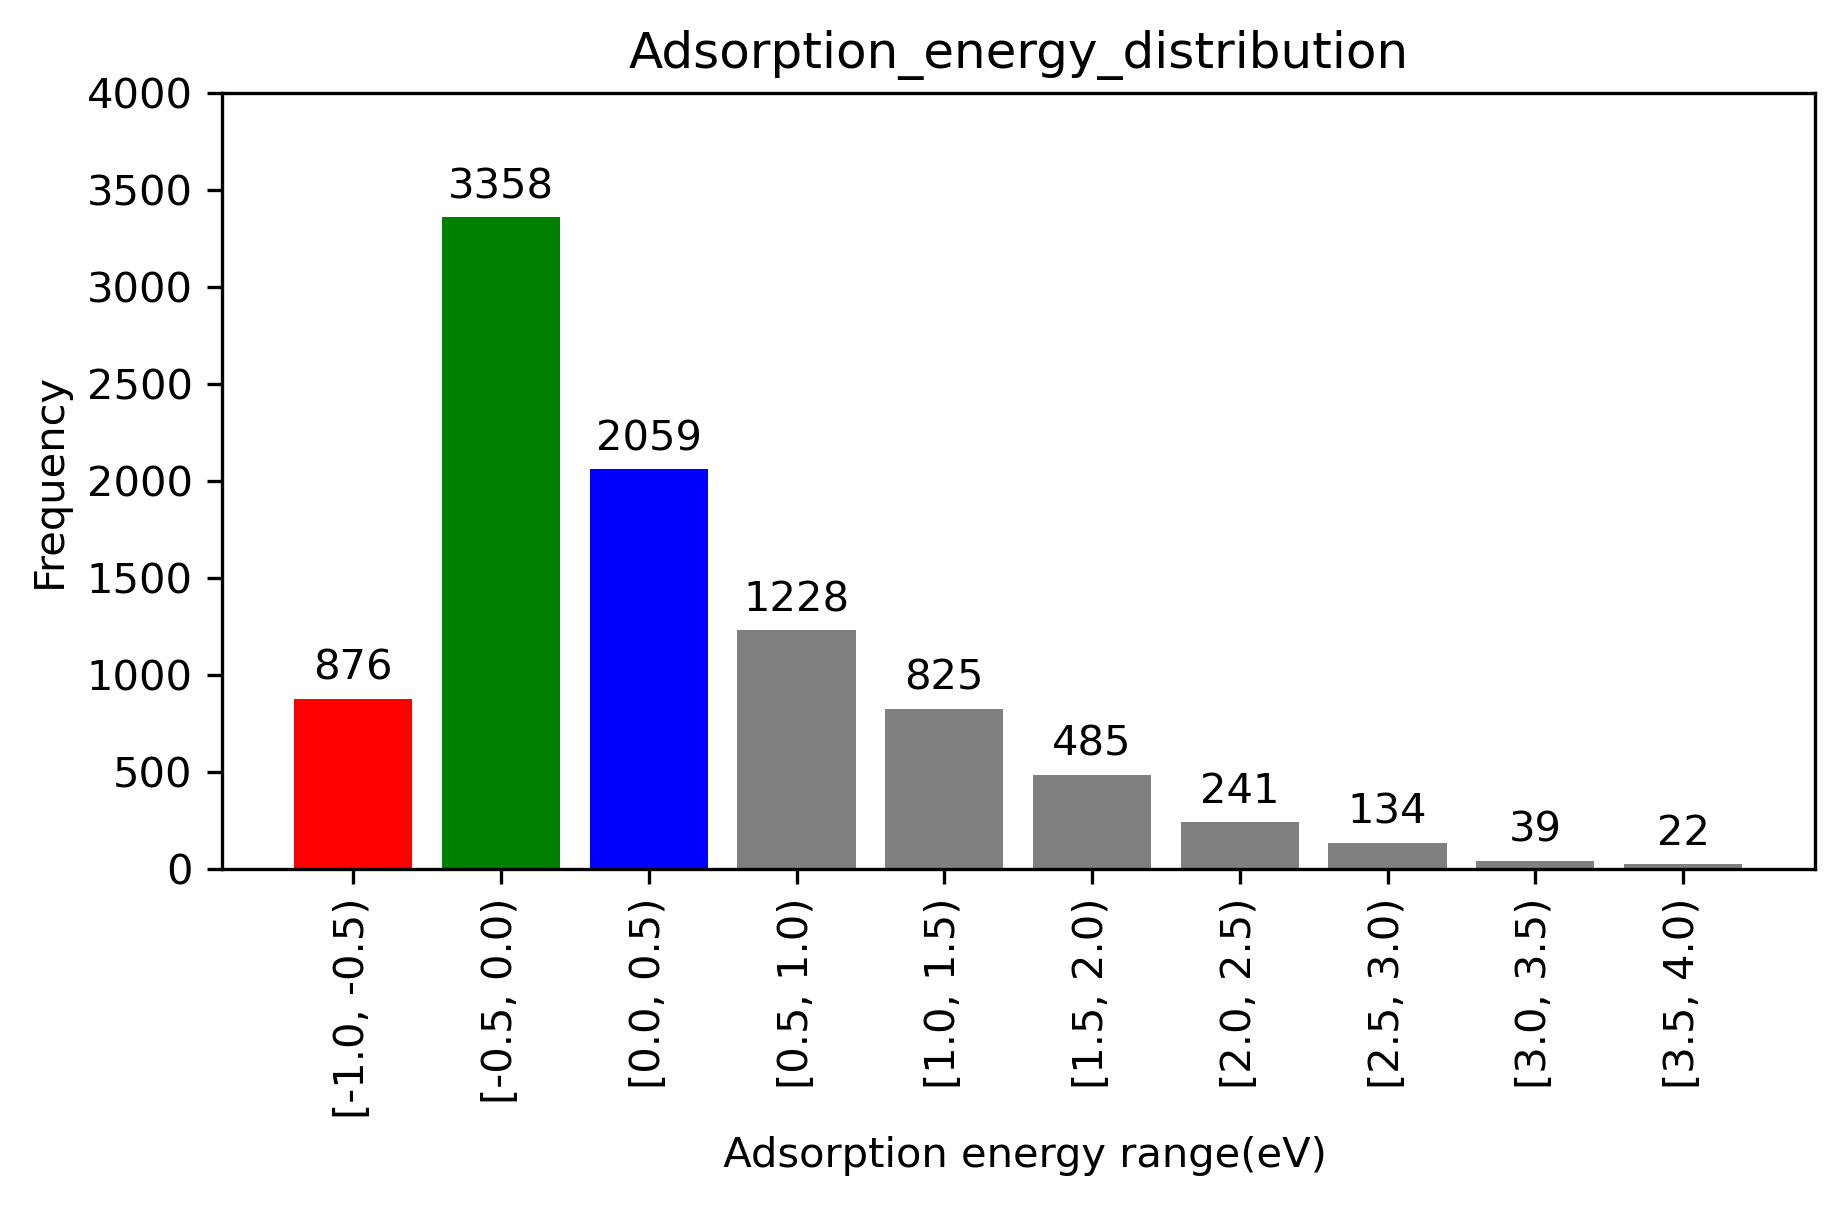

In [2]:
def count_values_in_intervals(data, interval_length):
    '''
    用于统计每个区间的数值个数及区间范围
    :param data: 待分析数据
    :param interval_length: 数据统计区间大小
    :return:
    interval_counts, interval_ranges
    '''    
    min_value = min(data) # 确定区间范围
    max_value = max(data)
    interval_start = math.floor(min_value / interval_length) * interval_length # 确定每个区间的起始值和结束值
    interval_end = math.ceil(max_value / interval_length) * interval_length
    num_intervals = int((interval_end - interval_start) / interval_length) # 计算区间数量
    interval_counts = [0] * num_intervals # 初始化每个区间的计数器和区间范围
    interval_ranges = []
    for i in range(num_intervals): # 遍历数据组，统计每个区间的数值个数
        start = interval_start + i * interval_length
        end = start + interval_length
        interval_ranges.append((start, end))
    for value in data:
        for i, (start, end) in enumerate(interval_ranges):
            if start <= value < end:
                interval_counts[i] += 1
                break
    return interval_counts, interval_ranges

energy_ptcluster = extract_data(adsorption_data_dir, E0, directory)['energy_atoms'] #从metadata中获取
print(len(energy_ptcluster))
interval_length = 0.5 # 设置统计区间大小为0.5
counts, ranges = count_values_in_intervals(energy_ptcluster, interval_length) # 统计每个区间的数值个数及区间范围

x_labels = [f"[{start}, {end})" for start, end in ranges] # 用于绘制数量分布直方图

plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
colors1 = ['red', 'green', 'blue'] + ['gray']*(len(x_labels)-3)
plt.bar(x_labels, counts, color=colors1)
plt.xlabel(" Adsorption energy range(eV)")
plt.ylabel("Frequency")
plt.title("Adsorption_energy_distribution")
plt.xticks(rotation='vertical',fontsize=10) 
plt.ylim(0, 4000)
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha="center",fontsize=10)
plt.savefig("/home/zhihengyu/WORK/Result/Picture/adsorption_energy_distribution.tif", dpi=300, bbox_inches='tight')
plt.show()

### 程序二：分别提取强吸附、弱吸附和弱排斥范围中的铂氢键长、吸附基尺寸及H位点配位数数据

In [1]:
from Bin.Calculate import extract_OSZICAR, MES
import numpy as np
from collections import Counter
#from ase.neighborlist import NeighborList
import matplotlib.pyplot as plt

# 元数据
adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]

def extract_adsorption_energy_range_data(data_path, E0, directory, e):
    '''
    提取计算数据存于system中
    :param data_path:待分析数据文件的保存路径
    :return:
    system{
        ['atoms']:              list,
        ['energy_atoms']:       list
        }
    '''
    import os
    import numpy as np
    from ase.io import vasp
    atoms_ptcluster = list()
    energy_ptcluster = list()
    system = {}
    for dir in directory:
        target_dir = data_path + dir
        data_dirs = os.listdir(target_dir)
        for data_dir in data_dirs:
            if data_dir.isdecimal():
                contcar = target_dir + "/" + data_dir + "/" + "CONTCAR"
                oszicar = target_dir + "/" + data_dir + "/" + "OSZICAR"
                oszicar_data = extract_OSZICAR(oszicar)
                # 吸附能：Adopation_energy = E_ptH - E_pt - 0.5E_H2
                energy_pt = oszicar_data['energy_atom'] - E0[dir] - 0.5 * E0["H2"]
                num_elec_steps = oszicar_data['num_elec_steps']
                if energy_pt > e and energy_pt <= e+0.5 and num_elec_steps <= 60:
                    atoms_ptcluster.append(vasp.read_vasp(contcar))
                    energy_ptcluster.append(energy_pt)
    
    system['atoms'] = np.array(atoms_ptcluster,dtype=object)
    system['energy_atoms'] = np.array(energy_ptcluster)
    return system

colors = ['red', 'green', 'blue']  # 标记颜色
energies = [-1, -0.5, 0]  # 不同 e 对应的能量值
labels = ['Strong adsorption', 'Weak adsorption', 'Weak rejection']  # 图例标签


#### 铂氢键长: dPt_H. Figure 3(b) Analysis of the correlation between platinum-hydrogen bond length (<dPt-H>) distribution in different adsorption regions and adsorption energy.

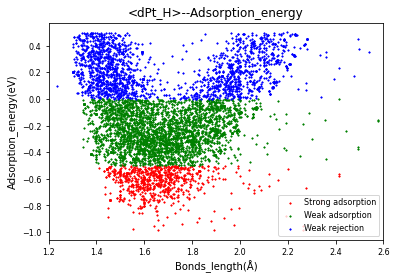

In [2]:
for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    min_distance = np.array([MES(atoms_ptcluster[i])['min_distance'] for i in range(len(atoms_ptcluster))])

    # 绘制散点图并设置颜色和标记
    
    plt.scatter(min_distance, energy_ptcluster, marker='D', c=colors[i], s=1, label=labels[i])

# 添加图例
plt.legend(prop={'size': 8},loc='lower right')
plt.xlim(1.2,2.6)
#plt.tick_params(axis='both', which='major', width=0.5, length=1)  # 主刻度线的粗细
plt.title('<dPt_H>--Adsorption_energy', fontsize=12)
plt.xlabel('Bonds_length(Å)', fontsize=10)
plt.ylabel('Adsorption_energy(eV)', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Bonds_length_Pt-H--Adsorption_energy.tif", dpi=300, bbox_inches='tight')
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Bonds_length_Pt-H--Adsorption_energy.svg", dpi=300, bbox_inches='tight')
plt.show()


#### 吸附基尺寸: S_r. Figure 3(c) Analysis of the correlation between the distribution of adsorption cluster size radius in different adsorption regions and adsorption energy.

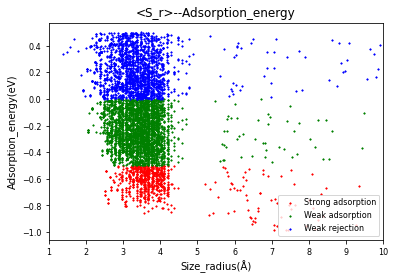

In [3]:
colors = ['red', 'green', 'blue']  # 标记颜色
energies = [-1, -0.5, 0]  # 不同 e 对应的能量值
labels = ['Strong adsorption', 'Weak adsorption', 'Weak rejection']  # 图例标签
for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])

    # 绘制散点图并设置颜色和标记
    plt.scatter(radius, energy_ptcluster, marker='D', c=colors[i], s=1, label=labels[i])

# 添加图例
plt.legend(prop={'size': 8},loc='lower right')
plt.xlim(1,10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('<S_r>--Adsorption_energy', fontsize=12)
plt.xlabel('Size_radius(Å)', fontsize=10)
plt.ylabel('Adsorption_energy(eV)', fontsize=10)
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Size_radius--Adsorption_energy.tif", dpi=300, bbox_inches='tight')
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Size_radius--Adsorption_energy.svg", dpi=300, bbox_inches='tight')
plt.show()

#### 吸附基尺寸分布 Figure 3(d) The proportion of the distribution of adsorption substrate size in different adsorption regions

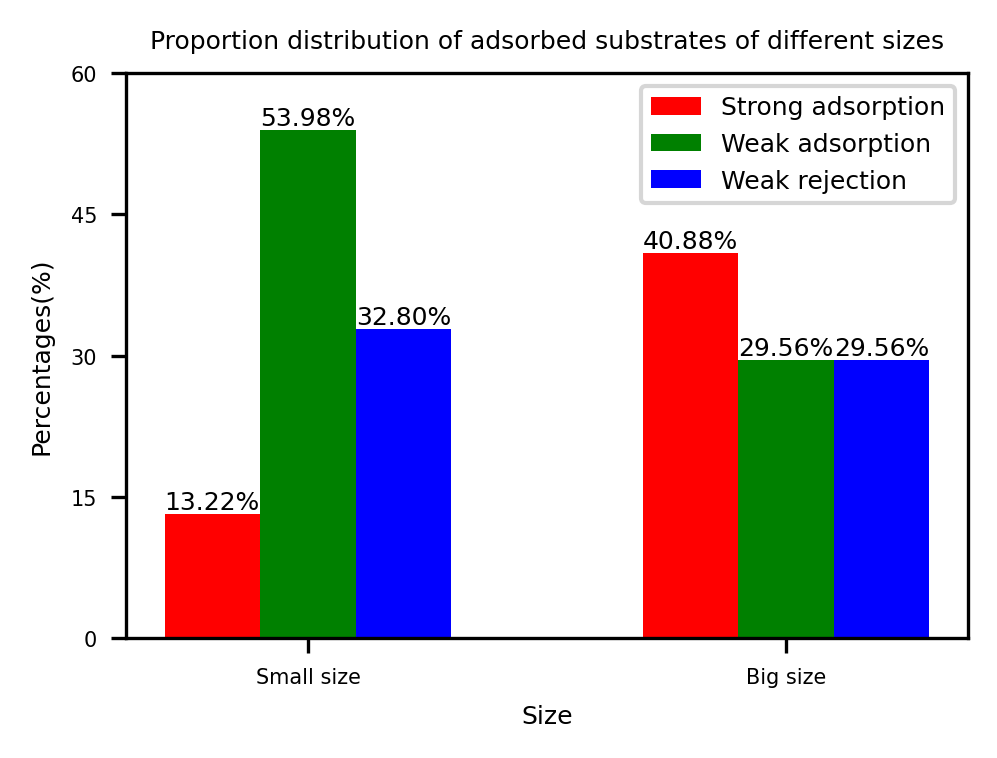

In [4]:
import numpy as np
import matplotlib.pyplot as plt

size_counts = [[0, 0, 0], [0, 0, 0]]
x_labels = ['Small size', 'Big size']

# 统计区域数量
for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy = data_system['energy_atoms']
    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    for j in range(len(radius)):
        if radius[j] < 5.0:
            if energy[j] <-0.5:
                size_counts[0][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[0][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[0][2] += 1
        else:
            if energy[j] <-0.5:
                size_counts[1][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[1][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[1][2] += 1
small_size_counts = sum(size_counts[0])
big_size_counts = sum(size_counts[1])

percentages = [
    [size_counts[0][0] / small_size_counts * 100, size_counts[0][1] / small_size_counts * 100, size_counts[0][2] / small_size_counts * 100],
    [size_counts[1][0] / big_size_counts * 100, size_counts[1][1] / big_size_counts * 100, size_counts[1][2] / big_size_counts * 100]
]


# 绘图参数
width_mm = 87  # 宽度87mm
height_mm = 66.8  # 高度50mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
x = np.arange(len(x_labels))
width = 0.2
rects1 = ax.bar(x - width, [row[0] for row in percentages], width, label='Strong adsorption', color='red')
rects2 = ax.bar(x, [row[1] for row in percentages], width, label='Weak adsorption', color='green')
rects3 = ax.bar(x + width, [row[2] for row in percentages], width, label='Weak rejection', color='blue')

ax.set_xlabel('Size', fontsize=6)
ax.set_ylabel('Percentages(%)', fontsize=6)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=5)
ax.set_yticks([0,15,30,45,60])
ax.tick_params(axis='y', labelsize=5)
ax.legend(fontsize=6)

# 在每个柱状图正上方显示百分比
for i, rect1 in enumerate(rects1):
    height1 = rect1.get_height()
    ax.annotate(f'{percentages[i][0]:.2f}%', xy=(rect1.get_x() + rect1.get_width() / 2, height1), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=6)

for i, rect2 in enumerate(rects2):
    height2 = rect2.get_height()
    ax.annotate(f'{percentages[i][1]:.2f}%', xy=(rect2.get_x() + rect2.get_width() / 2, height2), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=6)

for i, rect3 in enumerate(rects3):
    height3 = rect3.get_height()
    ax.annotate(f'{percentages[i][2]:.2f}%', xy=(rect3.get_x() + rect3.get_width() / 2, height3), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=6)

plt.title('Proportion distribution of adsorbed substrates of different sizes', fontsize=6)
fig.tight_layout()
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Figure3c_Size_counts3.tif", dpi=300, bbox_inches='tight')
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Figure3c_Size_counts3.svg", dpi=300, bbox_inches='tight')
plt.show()


#### 分布草稿

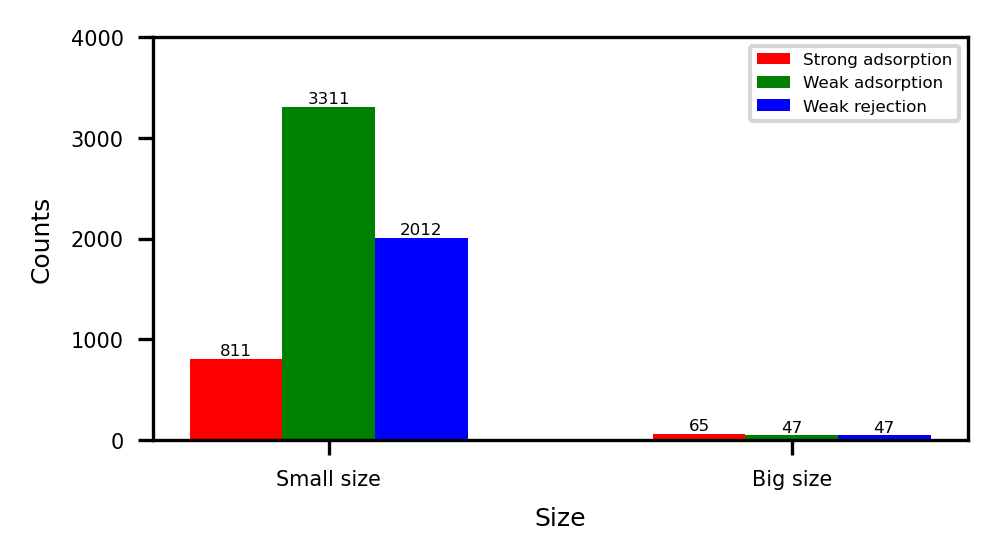

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

size_counts = [[0, 0, 0],[0, 0, 0]]
x_labels = ['Small size', 'Big size']

# 统计区域数量
for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy = data_system['energy_atoms']
    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    for j in range(len(radius)):
        if radius[j] < 5.0:
            if energy[j] <-0.5:
                size_counts[0][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[0][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[0][2] += 1
        else:
            if energy[j] <-0.5:
                size_counts[1][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[1][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[1][2] += 1

# 绘图参数
width_mm = 87  # 宽度87mm
height_mm = 50  # 高度50mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
x = np.arange(len(x_labels))
width = 0.2
rects1 = ax.bar(x - width, [row[0] for row in size_counts], width, label='Strong adsorption', color='red')
rects2 = ax.bar(x, [row[1] for row in size_counts], width, label='Weak adsorption', color='green')
rects3 = ax.bar(x + width, [row[2] for row in size_counts], width, label='Weak rejection', color='blue')

ax.set_xlabel('Size', fontsize=6)
ax.set_ylabel('Counts', fontsize=6)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=5)
ax.set_yticks([0,1000,2000,3000,4000])
ax.tick_params(axis='y', labelsize=5)
ax.legend(fontsize=4)
# 设置y轴刻度格式为科学计数法
#ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

# 在每个柱子正上方显示对应的数量
for i, rect1 in enumerate(rects1):
    height1 = rect1.get_height()
    ax.annotate(f'{size_counts[i][0]}', xy=(rect1.get_x() + rect1.get_width() / 2, height1), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)

for i, rect2 in enumerate(rects2):
    height2 = rect2.get_height()
    ax.annotate(f'{size_counts[i][1]}', xy=(rect2.get_x() + rect2.get_width() / 2, height2), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)

for i, rect3 in enumerate(rects3):
    height3 = rect3.get_height()
    ax.annotate(f'{size_counts[i][2]}', xy=(rect3.get_x() + rect3.get_width() / 2, height3), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)
fig.tight_layout()
plt.savefig("/home/zhihengyu/WORK/Result//Picture/Figure3c_Size_counts1.tif", dpi=300, bbox_inches='tight')
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Figure3c_Size_counts1.svg", dpi=300, bbox_inches='tight')
plt.show()

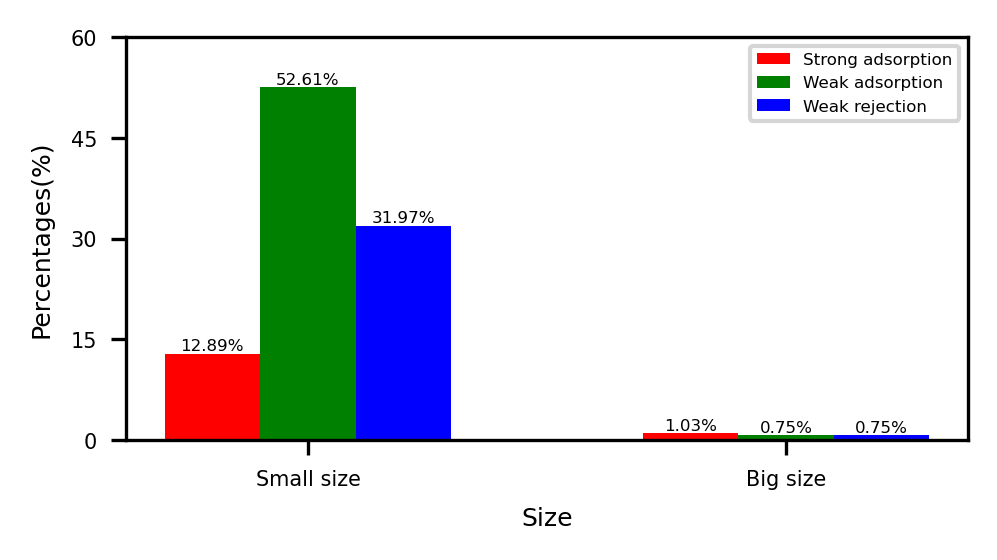

In [14]:
import numpy as np
import matplotlib.pyplot as plt

size_counts = [[0, 0, 0], [0, 0, 0]]
x_labels = ['Small size', 'Big size']

# 统计区域数量
for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy = data_system['energy_atoms']
    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    for j in range(len(radius)):
        if radius[j] < 5.0:
            if energy[j] <-0.5:
                size_counts[0][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[0][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[0][2] += 1
        else:
            if energy[j] <-0.5:
                size_counts[1][0] += 1
            elif energy[j] >= -0.5 and energy[j] < 0:
                size_counts[1][1] += 1
            elif energy[j] >=0 and energy[j] < 0.5:
                size_counts[1][2] += 1
total_counts = sum(sum(row) for row in size_counts)
percentages = [[count / total_counts * 100 for count in row] for row in size_counts]

# 绘图参数
width_mm = 87  # 宽度87mm
height_mm = 50  # 高度50mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)
x = np.arange(len(x_labels))
width = 0.2
rects1 = ax.bar(x - width, [row[0] for row in percentages], width, label='Strong adsorption', color='red')
rects2 = ax.bar(x, [row[1] for row in percentages], width, label='Weak adsorption', color='green')
rects3 = ax.bar(x + width, [row[2] for row in percentages], width, label='Weak rejection', color='blue')

ax.set_xlabel('Size', fontsize=6)
ax.set_ylabel('Percentages(%)', fontsize=6)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, fontsize=5)
ax.set_yticks([0,15,30,45,60])
ax.tick_params(axis='y', labelsize=5)
ax.legend(fontsize=4)

# 在每个柱状图正上方显示百分比
for i, rect1 in enumerate(rects1):
    height1 = rect1.get_height()
    ax.annotate(f'{percentages[i][0]:.2f}%', xy=(rect1.get_x() + rect1.get_width() / 2, height1), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)

for i, rect2 in enumerate(rects2):
    height2 = rect2.get_height()
    ax.annotate(f'{percentages[i][1]:.2f}%', xy=(rect2.get_x() + rect2.get_width() / 2, height2), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)

for i, rect3 in enumerate(rects3):
    height3 = rect3.get_height()
    ax.annotate(f'{percentages[i][2]:.2f}%', xy=(rect3.get_x() + rect3.get_width() / 2, height3), xytext=(0, 0),
                textcoords="offset points", ha='center', va='bottom', fontsize=4)

fig.tight_layout()
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Figure3c_Size_counts2.tif", dpi=300, bbox_inches='tight')
plt.savefig("/home/zhihengyu/WORK/Result/Picture/Figure3c_Size_counts2.svg", dpi=300, bbox_inches='tight')
plt.show()


#### Figure 5(d) Comparison of the quality of prediction of adsorption energy when using different descriptors/ML methods

In [1]:
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Bin.Calculate import MES
    from Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = np.array(atoms_ptcluster,dtype=object)[basis_index]
    basis_energy = np.array(energy_ptcluster)[basis_index]
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap = basis_Eigenvector
    soap_S_r = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)
    basis_sets = [soap, soap_S_r, soap_dPt_H, soap_dPt_H_S_r]
    '''
    basis_sets = [basis_Eigenvector,
                  np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1),
                  np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1),
                  np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)]
    '''
    # Train and test for different basis sets
    models = []
    train_scores = []
    test_scores = []
    for basis_set in basis_sets:
        X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
        kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e9))
        GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
        gpr = GPR.fit(X_train, y_train)
        #models.append(gpr)
        #joblib.dump(gpr, modelfile+'_T{}'.format(len(models)-1))
        GPR_x_train_pred = gpr.predict(X_train)
        GPR_x_test_pred = gpr.predict(X_test)
        train_scores.append([mean_absolute_error(y_train, GPR_x_train_pred), np.sqrt(mean_squared_error(y_train, GPR_x_train_pred)), r2_score(y_train, GPR_x_train_pred)])
        test_scores.append([mean_absolute_error(y_test, GPR_x_test_pred), np.sqrt(mean_squared_error(y_test, GPR_x_test_pred)), r2_score(y_test, GPR_x_test_pred)])
    return train_scores, test_scores

# Example usage
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
gpr_train_scores, gpr_test_scores = calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)
print('gpr_train_scores:',gpr_train_scores)
print('gpr_test_scores:',gpr_test_scores)


/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


gpr_train_scores: [[0.06478507454554565, 0.08810411679300026, 0.92729540967929], [0.10097235542424066, 0.13381509385273968, 0.8322820158740236], [0.09056075749590616, 0.12135130759034304, 0.8620701231679222], [0.10403045816146601, 0.13623937707345057, 0.8261499875099114]]
gpr_test_scores: [[0.1489822362507924, 0.2060480123654811, 0.6310023322624487], [0.12281576412148673, 0.16411439542747625, 0.7659114795603743], [0.13353385463387318, 0.175245943112399, 0.7330790215340515], [0.11982543040427984, 0.16053639159049354, 0.776007355941814]]


/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [4]:
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Code.Bin.Calculate import MES
    from Code.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = np.array(atoms_ptcluster,dtype=object)[basis_index]
    basis_energy = np.array(energy_ptcluster)[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap = basis_Eigenvector
    soap_S_r = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)
    basis_sets = [soap, soap_S_r, soap_dPt_H, soap_dPt_H_S_r]
    
    # Train and test for different basis sets
    models = []
    train_scores = []
    test_scores = []
    for basis_set in basis_sets:
        X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
        RFR = RandomForestRegressor(n_estimators=100, random_state=10)
        rfr = RFR.fit(X_train, y_train)
        RFR_x_train_pred = rfr.predict(X_train)
        RFR_x_test_pred = rfr.predict(X_test)
        train_scores.append([mean_absolute_error(y_train, RFR_x_train_pred), np.sqrt(mean_squared_error(y_train, RFR_x_train_pred)), r2_score(y_train, RFR_x_train_pred)])
        test_scores.append([mean_absolute_error(y_test, RFR_x_test_pred), np.sqrt(mean_squared_error(y_test, RFR_x_test_pred)), r2_score(y_test, RFR_x_test_pred)])
    return train_scores, test_scores

# Example usage
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
rfr_train_scores, rfr_test_scores = calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)
print('rfr_train_scores:',rfr_train_scores)
print('rfr_test_scores:',rfr_test_scores)


rfr_train_scores: [[0.058120640066666465, 0.07575902036047957, 0.9462426157971675], [0.05525142246666666, 0.07171565568103346, 0.9518277008552525], [0.05341693411666648, 0.0700021191525211, 0.9541022070260519], [0.05096263826666662, 0.06630878868271536, 0.9588176034187958]]
rfr_test_scores: [[0.15650856584999975, 0.1948621321768027, 0.6699789339772184], [0.14908511092499993, 0.18677250076328172, 0.6968115660828842], [0.14921950074999962, 0.18932451940268605, 0.6884695601035549], [0.13949981049999993, 0.17695020605543035, 0.7278621761381141]]


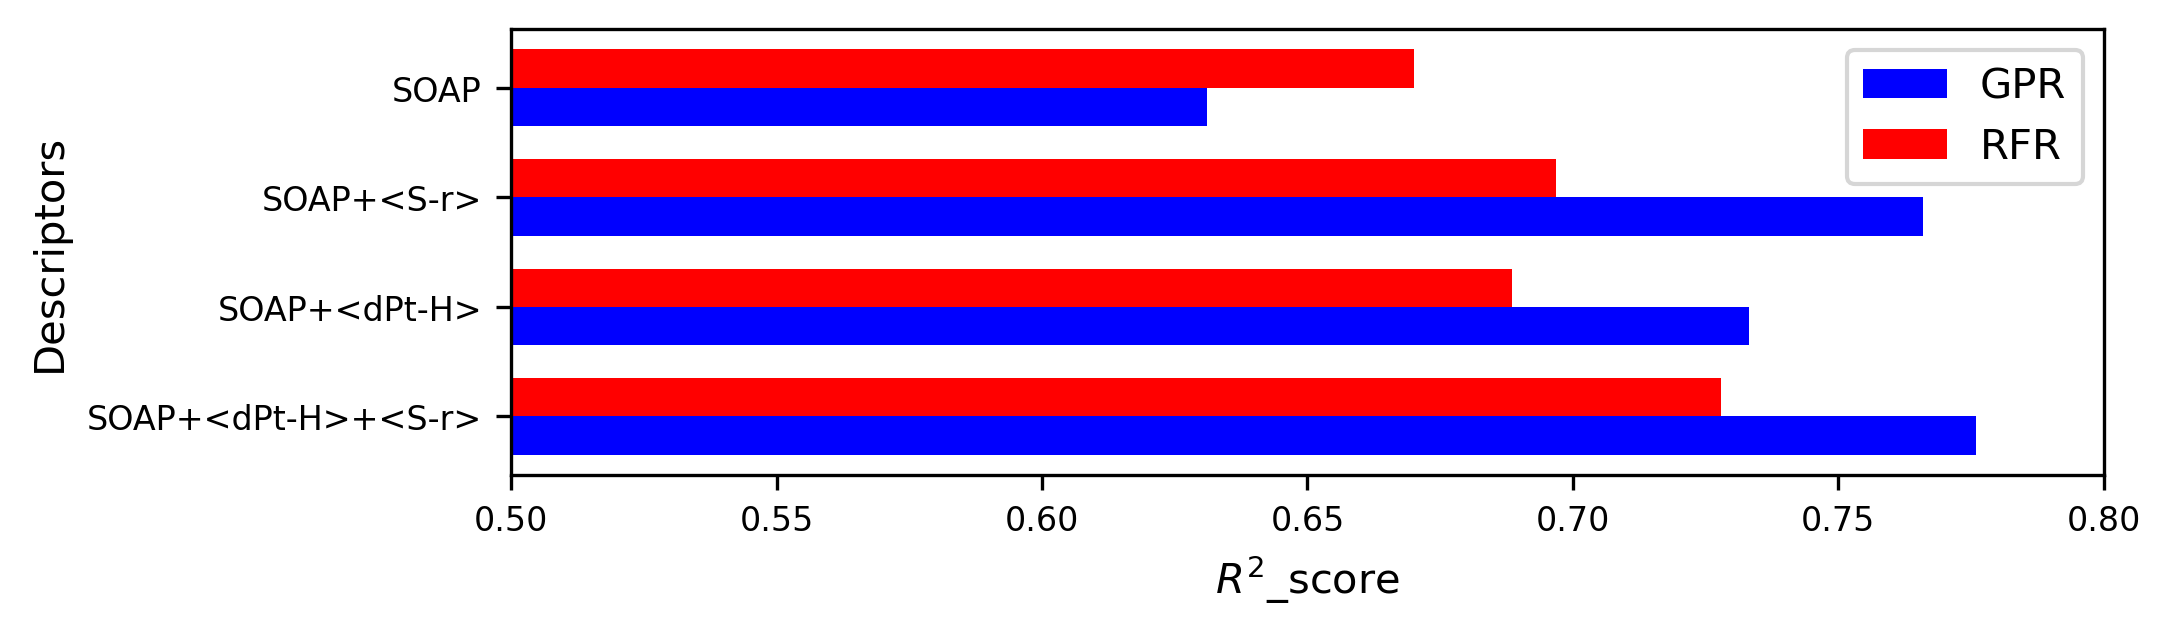

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
descriptors_name = ['SOAP+<dPt-H>+<S-r>', 'SOAP+<dPt-H>', 'SOAP+<S-r>', 'SOAP']
values1 = [0.7760, 0.7331, 0.7659, 0.6310]
values2 = [0.7279, 0.6885, 0.6968, 0.6700]

# 绘图
width_mm = 174  # 宽度80mm
height_mm = 50  # 高度30mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)

bar_width = 0.35
index = np.arange(len(descriptors_name))

bar1 = ax.barh(index - bar_width/2, [x for x in values1], bar_width, label='GPR', color='b')
bar2 = ax.barh(index + bar_width/2, [x for x in values2], bar_width, label='RFR', color='r')

# 设置标签和标题
ax.set_xlabel('$R^2$_score', fontsize=10)
ax.set_ylabel('Descriptors', fontsize=10)

# 设置y轴刻度标签字体大小
ax.set_yticks(index)
ax.set_yticklabels(descriptors_name, fontsize=8)

# 设置横坐标显示范围和间距
ax.set_xlim(0.50, 0.80)
ax.set_xticks(np.arange(0.5, 0.80, 0.05))
ax.set_xticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=8)

# 显示图例
ax.legend()
plt.savefig("/home/zhihengyu/WORK/Result/Picture/descriptors_contribution_all.tif", dpi=300, bbox_inches='tight')
# 显示图形
plt.show()


#### Figure 5(a)~(c) It shows the predicted results of GPR and RFR models using different descriptors

GPR_test_MAE: 0.14898223645098793
GPR_test_RMSE: 0.2060480123873991
GPR_test_R2: 0.6310023321839457


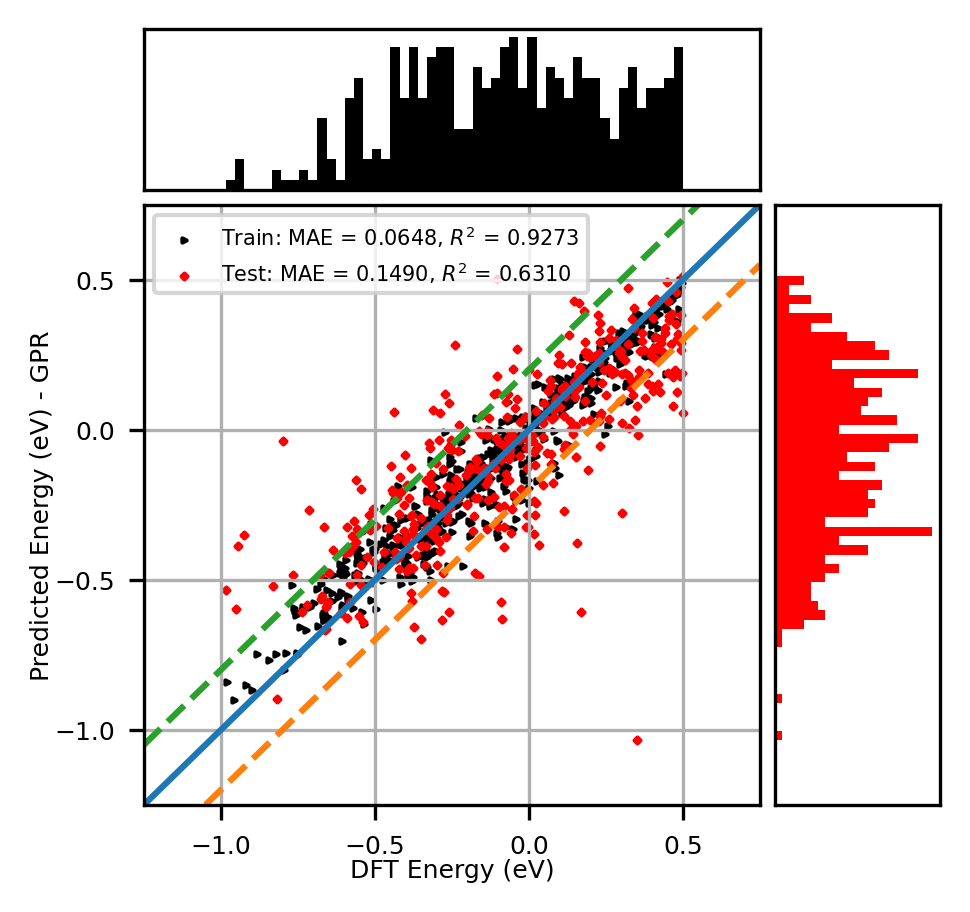

RFR_test_MAE: 0.15650856584999975
RFR_test_RMSE: 0.1948621321768027
RFR_test_R2: 0.6699789339772184


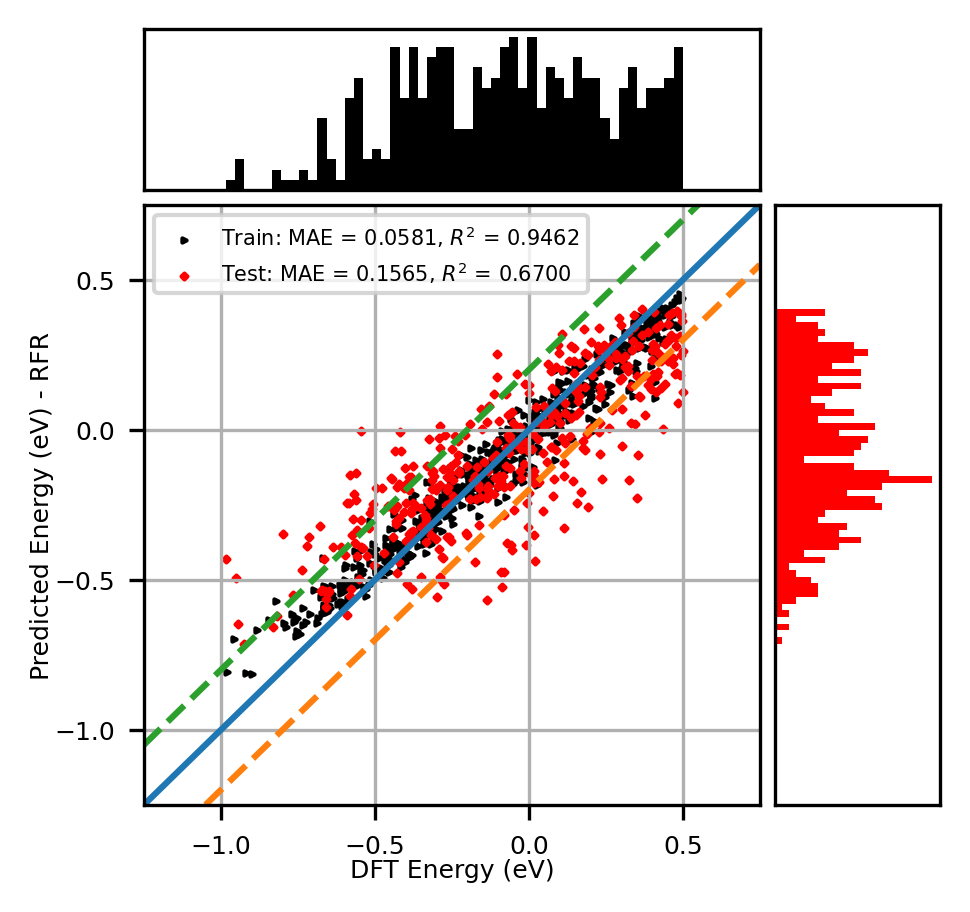

/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR_test_MAE: 0.12281561532925438
GPR_test_RMSE: 0.1641128927494623
GPR_test_R2: 0.7659157663027001


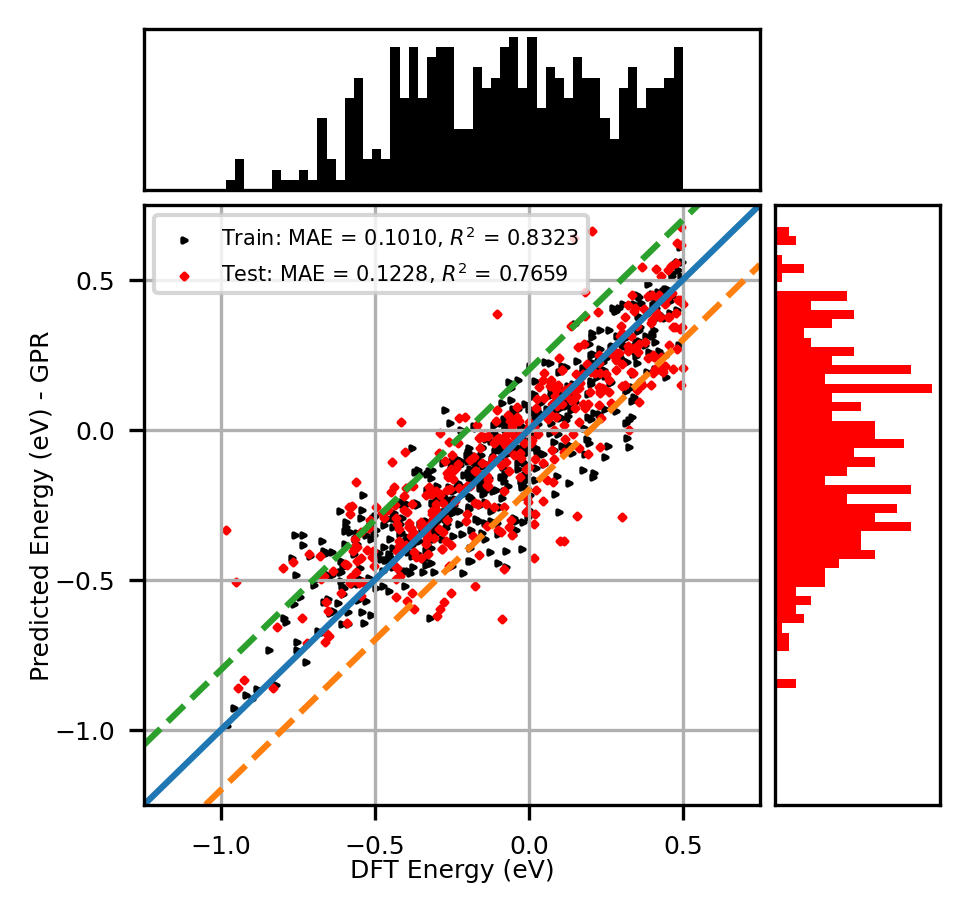

RFR_test_MAE: 0.14908511092499993
RFR_test_RMSE: 0.18677250076328172
RFR_test_R2: 0.6968115660828842


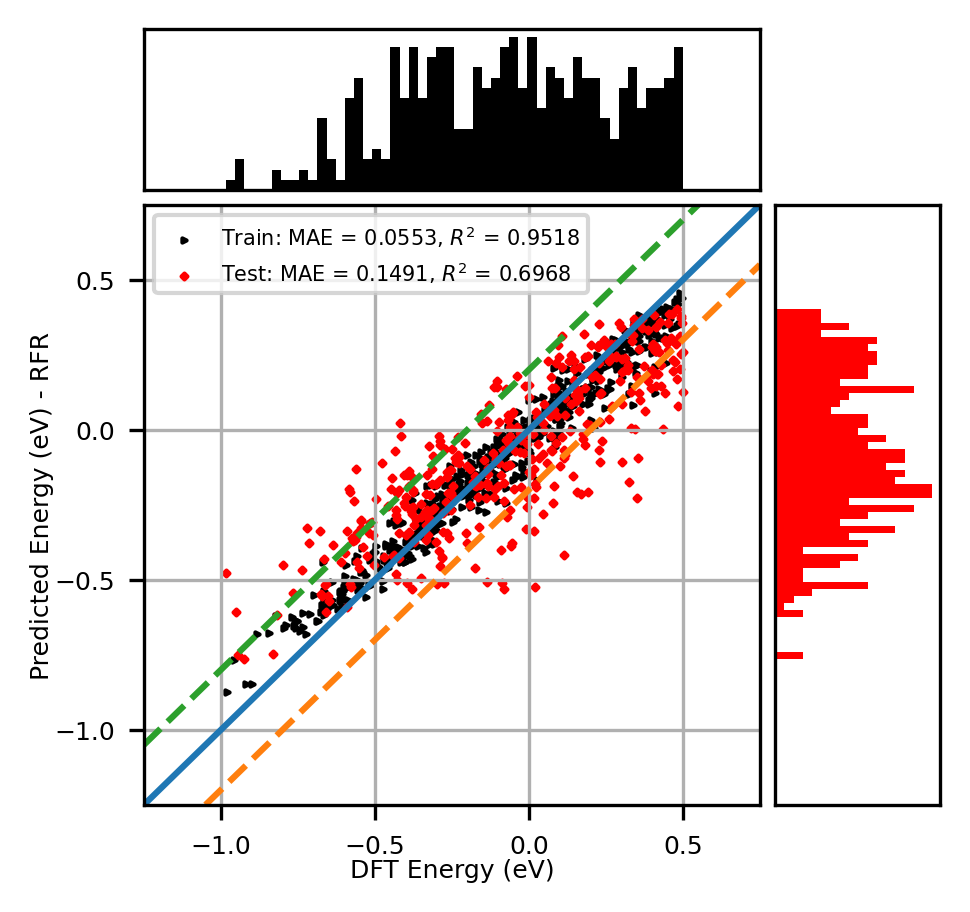

GPR_test_MAE: 0.13353385374236157
GPR_test_RMSE: 0.17524594128377022
GPR_test_R2: 0.7330790271045015


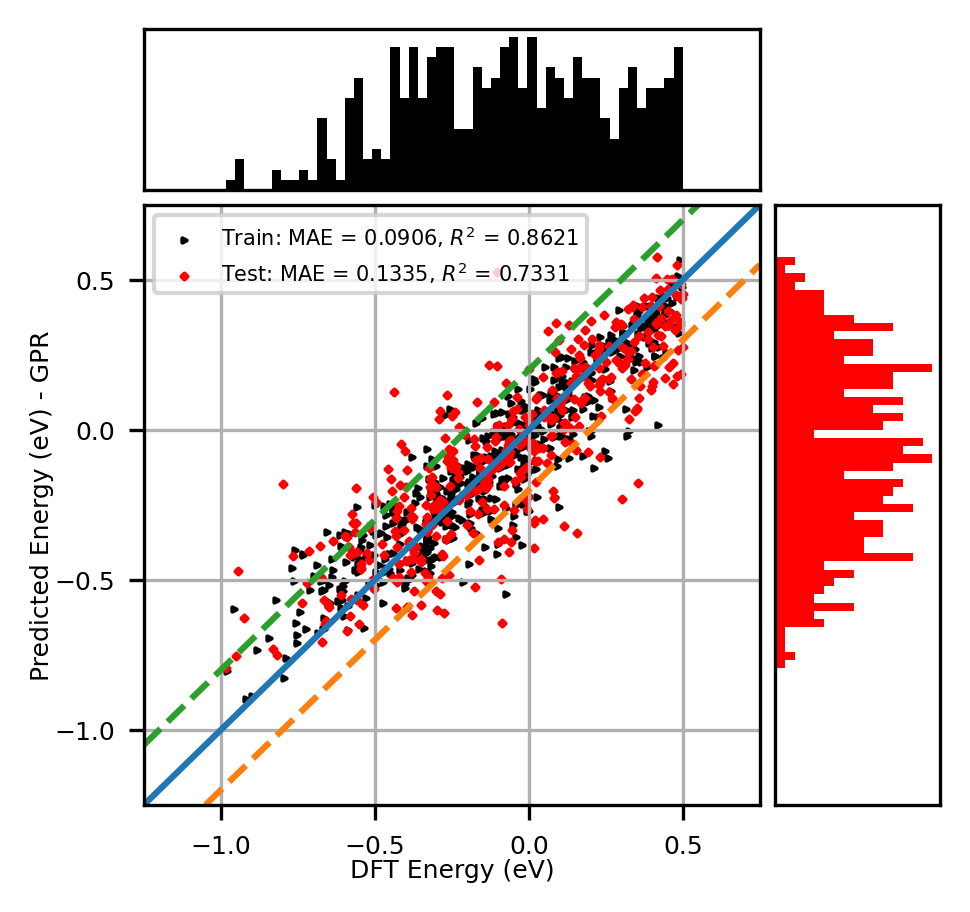

RFR_test_MAE: 0.14921950074999962
RFR_test_RMSE: 0.18932451940268605
RFR_test_R2: 0.6884695601035549


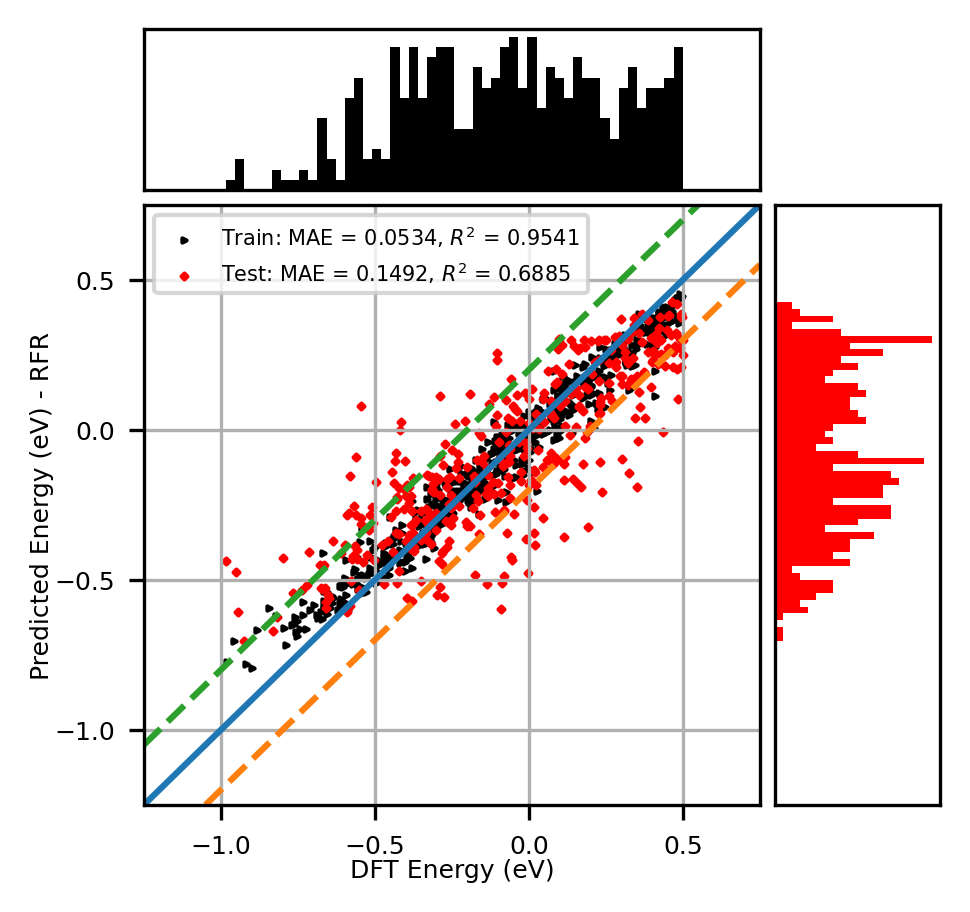

/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR_test_MAE: 0.11982543001079606
GPR_test_RMSE: 0.16053639149792215
GPR_test_R2: 0.7760073562001394


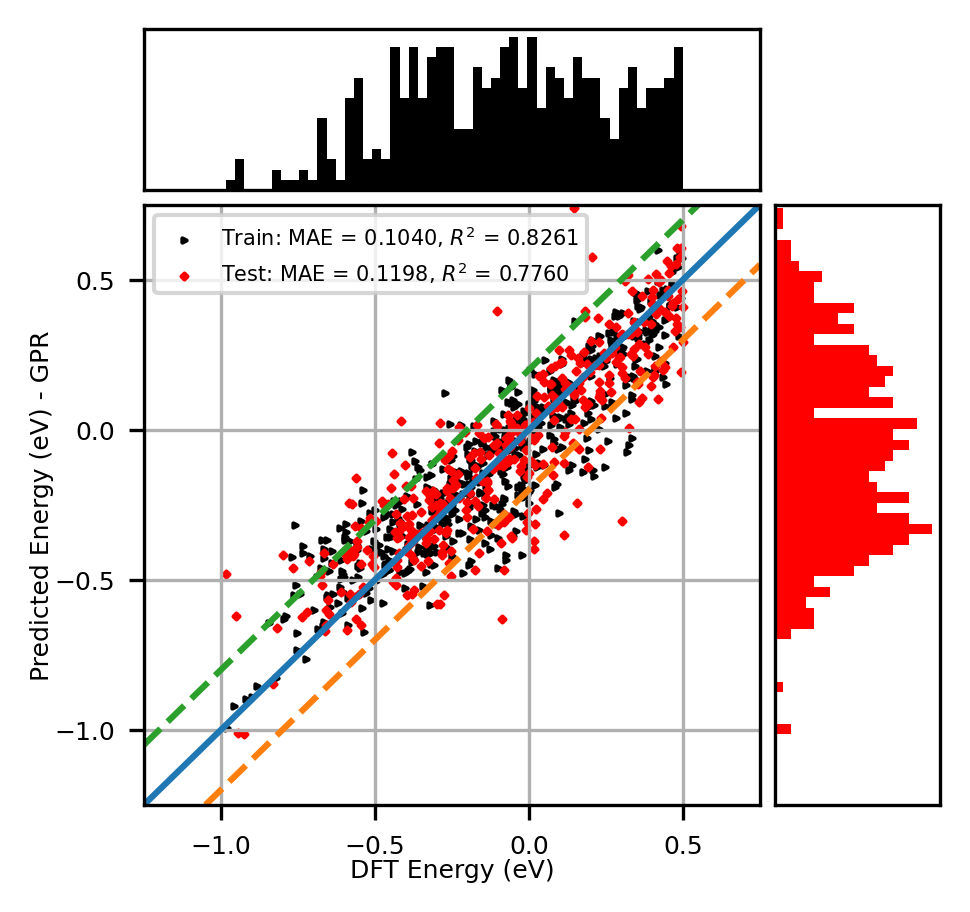

RFR_test_MAE: 0.13949981049999993
RFR_test_RMSE: 0.17695020605543035
RFR_test_R2: 0.7278621761381141


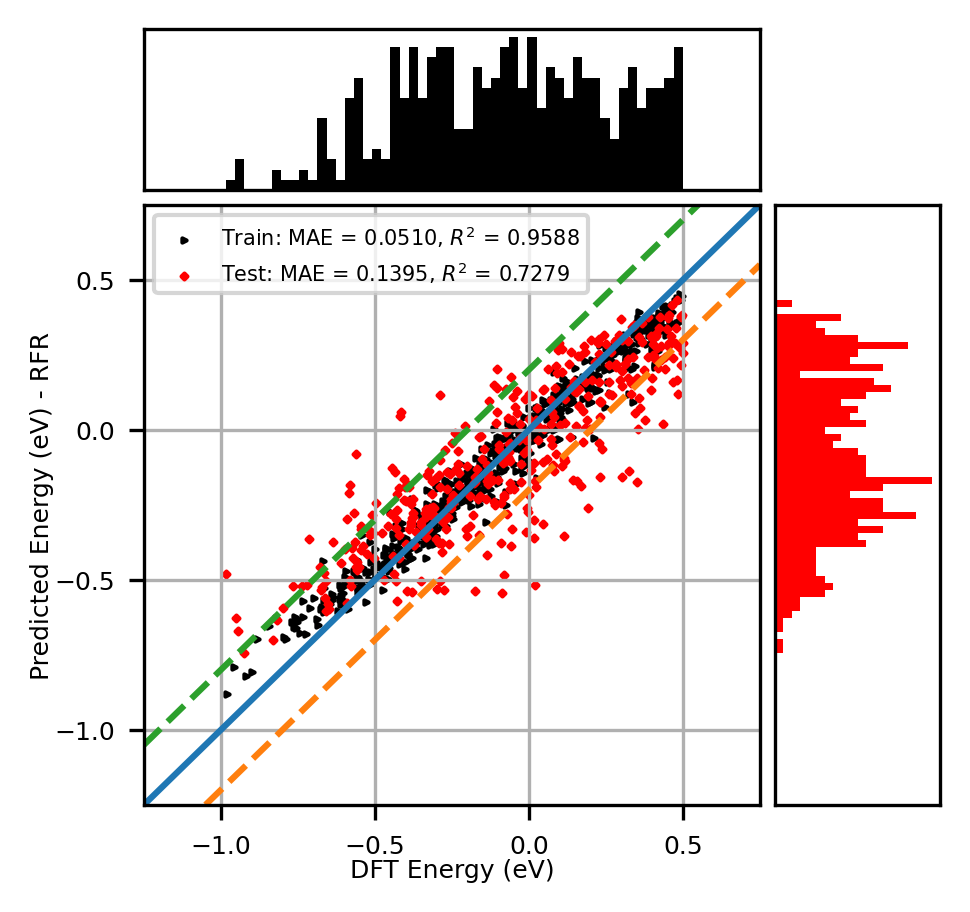

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

def plot_results(y_train, ML_x_train_pred, y_test, ML_x_test_pred, ML_train_MAE, ML_train_R2, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_train = ax3.scatter(y_train, ML_x_train_pred, marker='>', c='k', s=1, label="Train data")
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    plt.legend((ML_train, ML_test),
               ("Train: {}, {}".format("MAE = {:.4f}".format(ML_train_MAE),
                                          "$R^2$ = {:.4f}".format(ML_train_R2)),
                "Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),
                                      "$R^2$ = {:.4f}".format(ML_test_R2))),
               loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()

def calculate_GPR(X_train, X_test, y_train, y_test, model_name, figname):
    kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e6))
    GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    GPR.fit(X_train, y_train)
    GPR_x_train_pred = GPR.predict(X_train)
    GPR_x_test_pred = GPR.predict(X_test)
    GPR_train_MAE = mean_absolute_error(y_train, GPR_x_train_pred)
    GPR_train_R2 = r2_score(y_train, GPR_x_train_pred)
    GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
    GPR_test_R2 = r2_score(y_test, GPR_x_test_pred)
    GPR_test_RMSE = np.sqrt(mean_squared_error(y_test, GPR_x_test_pred))
    print("GPR_test_MAE:",GPR_test_MAE)
    print("GPR_test_RMSE:",GPR_test_RMSE)
    print("GPR_test_R2:",GPR_test_R2)
    plot_results(y_train, GPR_x_train_pred, y_test, GPR_x_test_pred, GPR_train_MAE, GPR_train_R2, GPR_test_MAE, GPR_test_R2, model_name, figname)

def calculate_RFR(X_train, X_test, y_train, y_test, model_name, figname):
    RFR = RandomForestRegressor(n_estimators=100, random_state=10)
    RFR.fit(X_train, y_train)
    RFR_x_train_pred = RFR.predict(X_train)
    RFR_x_test_pred = RFR.predict(X_test)
    RFR_train_MAE = mean_absolute_error(y_train, RFR_x_train_pred)
    RFR_train_R2 = r2_score(y_train, RFR_x_train_pred)
    RFR_test_MAE = mean_absolute_error(y_test, RFR_x_test_pred)
    RFR_test_R2 = r2_score(y_test, RFR_x_test_pred)
    RFR_test_RMSE = np.sqrt(mean_squared_error(y_test, RFR_x_test_pred))
    print("RFR_test_MAE:",RFR_test_MAE)
    print("RFR_test_RMSE:",RFR_test_RMSE)
    print("RFR_test_R2:",RFR_test_R2)
    plot_results(y_train, RFR_x_train_pred, y_test, RFR_x_test_pred, RFR_train_MAE, RFR_train_R2, RFR_test_MAE, RFR_test_R2, model_name, figname)

# Rest of the code for data loading and SOAP calculation remains the same
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Code.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Code.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = np.array(atoms_ptcluster,dtype=object)[basis_index]
    basis_energy = np.array(energy_ptcluster)[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap = basis_Eigenvector
    soap_S_r = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)
    basis_sets = [soap, soap_S_r, soap_dPt_H, soap_dPt_H_S_r]
     
    # Train and test for different basis sets
    for i, basis_set in enumerate(basis_sets):
        X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
        calculate_GPR(X_train, X_test, y_train, y_test, 'GPR', 'GPR_'+str(i))
        calculate_RFR(X_train, X_test, y_train, y_test, 'RFR', 'RFR_'+str(i))
    return

# Example
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)


#### 吸附能预测模型生成 （GPR——SOAP_dPt-H_S_r)
生成预测模型，并将其保存为MLGPR_P_soap-dpth-sr.pkl文件，用于后续的预测程序

In [4]:
#用来生成预测模型
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
import joblib
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import get_basis_sets_by_KMeans
from sklearn.model_selection import train_test_split
from Code.Bin.Calculate import MES

def calculate_GPR_P(soap_dPt_H_S_r, basis_energy):
    kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e6))
    GPR_P = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    X_train, X_test, y_train, y_test = train_test_split(soap_dPt_H_S_r, basis_energy, test_size=0.4, random_state=10)
    GPR_P.fit(X_train, y_train)
    joblib.dump(GPR_P, "/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")

def create_energy_prediction(atoms_ptcluster, energy_ptcluster):
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = np.array(atoms_ptcluster,dtype=object)[basis_index]
    basis_energy = np.array(energy_ptcluster)[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_min_distance.reshape(-1, 1)), axis=1), basis_radius.reshape(-1, 1)), axis=1)
   
    calculate_GPR_P(soap_dPt_H_S_r, basis_energy)

# Example

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

create_energy_prediction(atoms_ptcluster, energy_ptcluster)


/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/zhihengyu/miniconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Figure 6 Using 'SOAP-dpth-Sr' as a descriptor for GPR model to predict adsorption energy 
使用上述预测模型预测pt17的结果

In [1]:
import numpy as np
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import MES
import joblib

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt17"]

data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
HCoord = [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster]
HEnergy = energy_ptcluster

# Calculate SOAP descriptors
soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
Eigenvector = Eigenvector[:, 0, :]
#Predict other sets
pending_Eigenvector = Eigenvector
pending_atoms = atoms_ptcluster
pending_energy = energy_ptcluster
pending_min_distance = np.array([MES(pending_atoms[i])['min_distance'] for i in range(len(pending_atoms))])
pending_radius = np.array([MES(pending_atoms[i])['radius'] for i in range(len(pending_atoms))]) 
# Define different basis sets
soap_dPt_H_S_r_other = np.concatenate((np.concatenate((pending_Eigenvector, pending_min_distance.reshape(-1, 1)), axis=1), pending_radius.reshape(-1, 1)), axis=1)


def predict_HEnergy(soap_dPt_H_S_r_other):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    HEnergy_pred = GPRP.predict(soap_dPt_H_S_r_other)
    return HEnergy_pred

HEnergy_pred = predict_HEnergy(soap_dPt_H_S_r_other)
HCoordl = np.array([coord[0] for coord in HCoord])
HEnergy_difference = HEnergy_pred - HEnergy

    

##### Figure 6(a) DFT

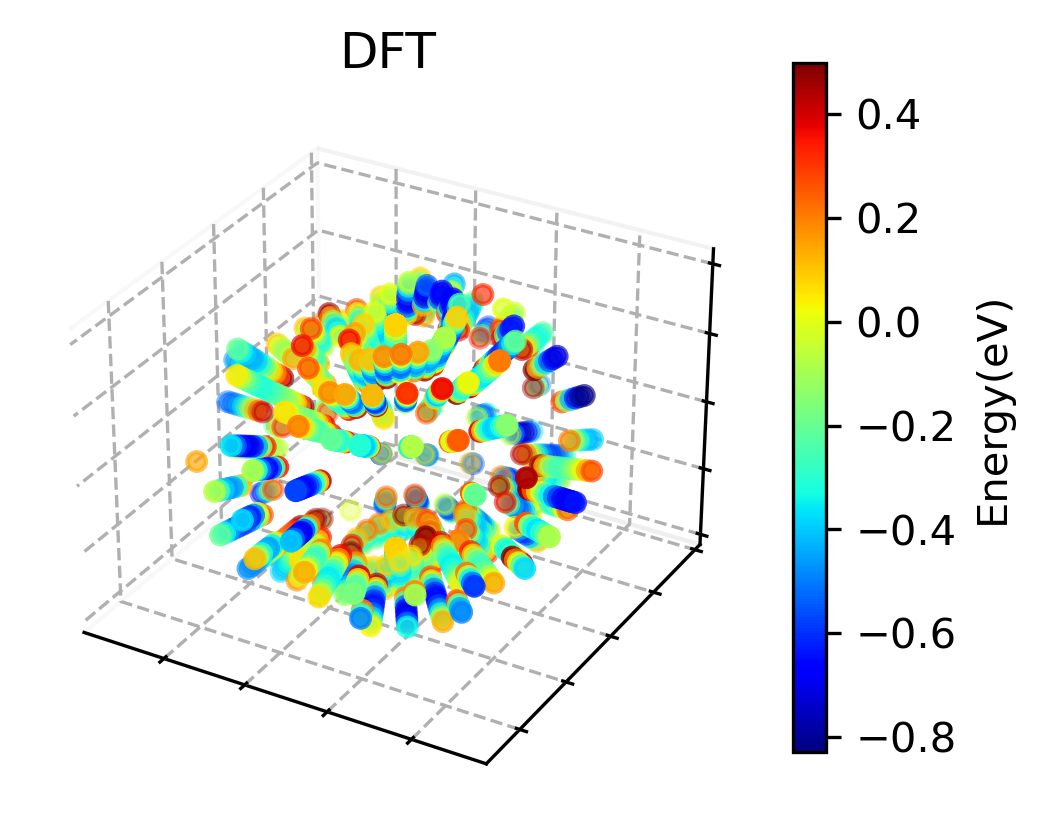

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_DFT(HCoord, HEnergy):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('DFT')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    ax2.set_ylabel('Energy(eV)')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_DFT.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_DFT.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_DFT(HCoordl, HEnergy)


##### Figure 6(b) Predicted

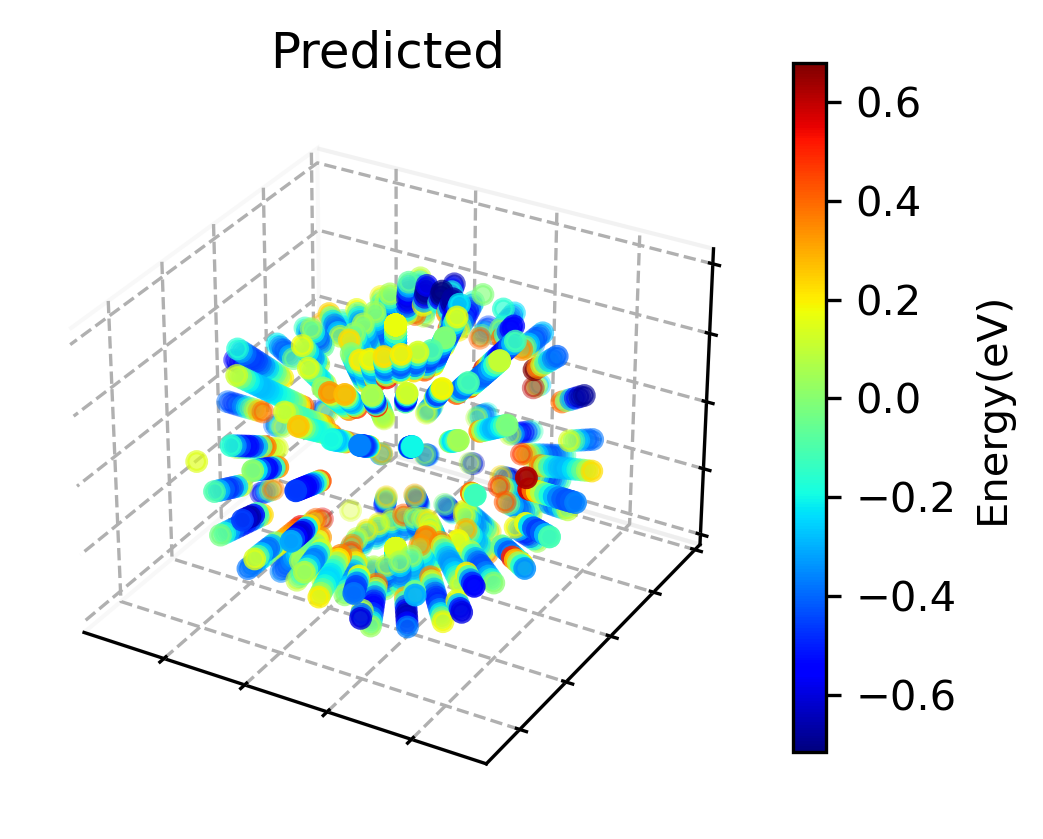

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Pred(HCoord, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Predicted')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    ax2.set_ylabel('Energy(eV)')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_Pred.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_Pred.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_Pred(HCoordl, HEnergy_pred)


##### Figure 6(c) Error

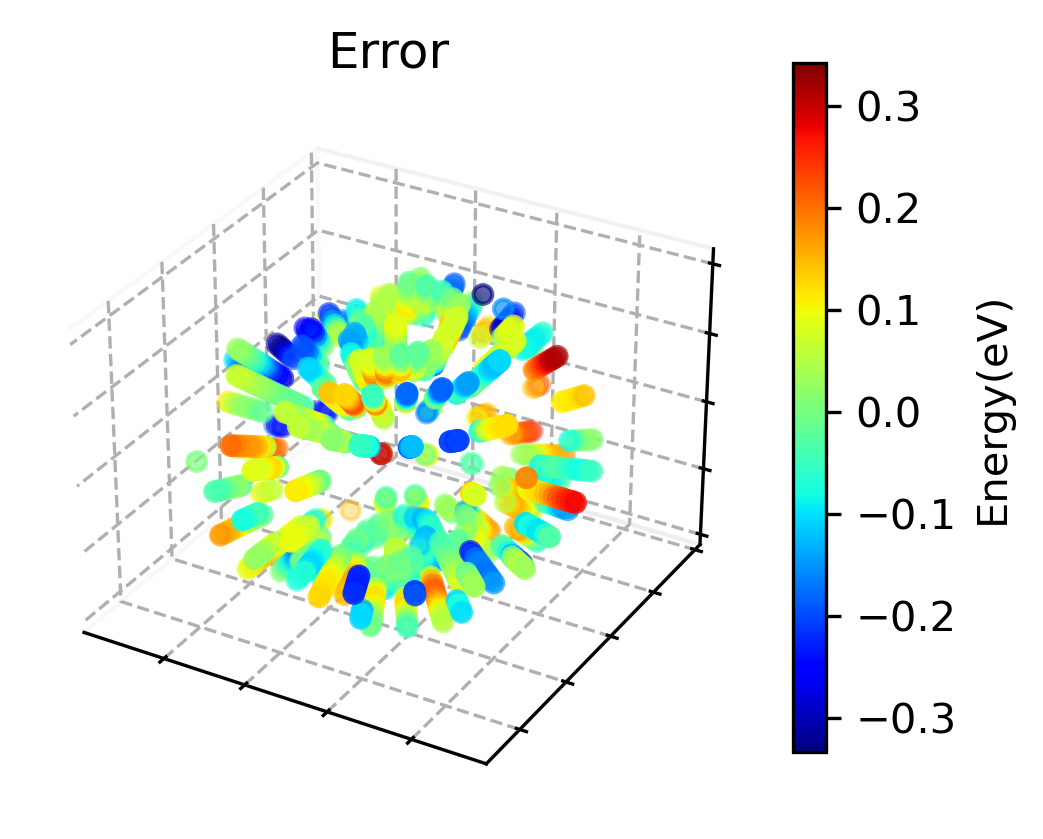

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Error(HCoord, HEnergy_difference):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=dpi)

    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Error')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_difference, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    ax2.set_ylabel('Energy(eV)')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_Error.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17_Error.svg",dpi=300, bbox_inches='tight')

    plt.show()


plot_3d_scatter_Error(HCoordl, HEnergy_difference)


##### Figure S2 The predicted quality of hydrogen adsorption energy on Pt17 of the model

GPRP_test_MAE: 0.07620244164858904
GPRP_test_RMSE: 0.09945240577712813
GPRP_test_R2: 0.8614194560441417


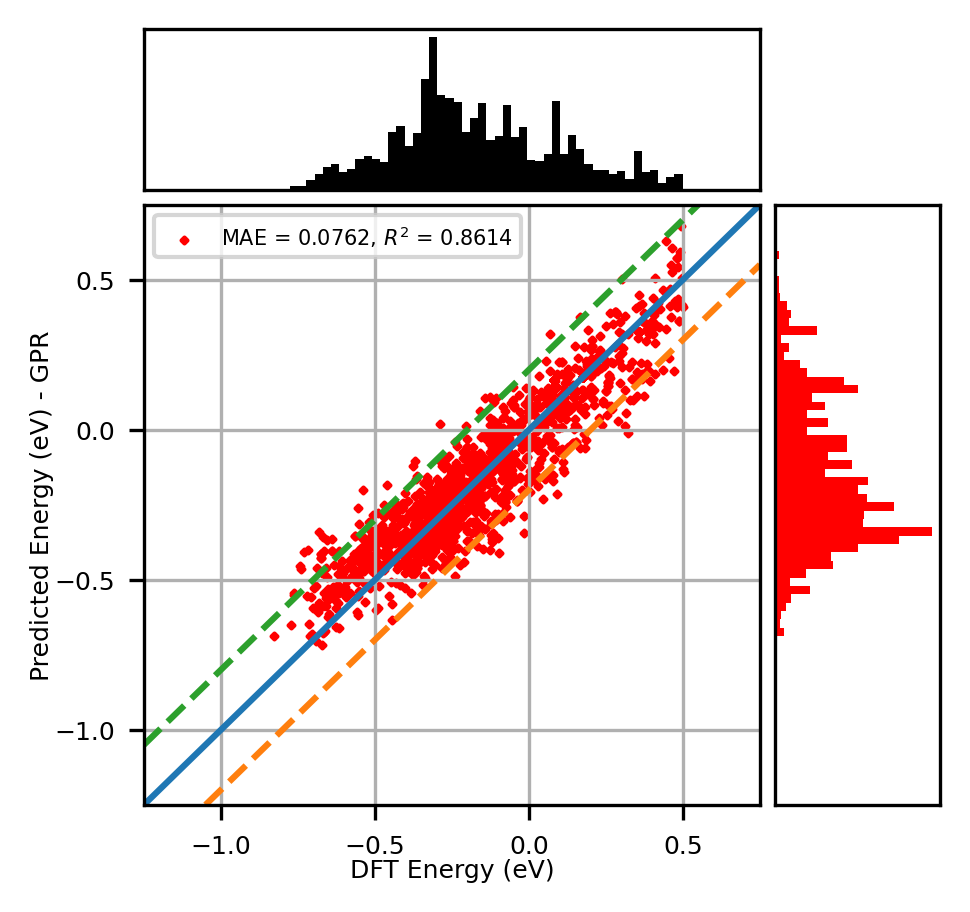

1651


In [1]:
#用已训练所得的model预测
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import get_basis_sets_by_KMeans
from Code.Bin.Calculate import MES


def plot_results(y_test, ML_x_test_pred, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    ax3.legend(handles=[ML_test], labels=["{}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2))], loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()
    
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, model_name, figname):
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    #Predict other sets
    other_Eigenvector = Eigenvector
    other_atoms = atoms_ptcluster
    other_energy = energy_ptcluster

    other_min_distance = np.array([MES(other_atoms[i])['min_distance'] for i in range(len(other_atoms))])
    other_radius = np.array([MES(other_atoms[i])['radius'] for i in range(len(other_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r_other = np.concatenate((np.concatenate((other_Eigenvector, other_min_distance.reshape(-1, 1)), axis=1), other_radius.reshape(-1, 1)), axis=1)
    predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname)
    return

def predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    X_test = soap_dPt_H_S_r_other
    y_test = other_energy
    
    GPRP_x_test_pred = GPRP.predict(X_test)
    GPRP_test_MAE = mean_absolute_error(y_test, GPRP_x_test_pred)
    GPRP_test_R2 = r2_score(y_test, GPRP_x_test_pred)
    GPRP_test_RMSE = np.sqrt(mean_squared_error(y_test, GPRP_x_test_pred))
    print("GPRP_test_MAE:",GPRP_test_MAE)
    print("GPRP_test_RMSE:",GPRP_test_RMSE)
    print("GPRP_test_R2:",GPRP_test_R2)
    plot_results(y_test, GPRP_x_test_pred, GPRP_test_MAE, GPRP_test_R2, model_name, figname)

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt17"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, 'GPR', 'MLGPR_P-soap-dpth-sr_pt17')
print(len(atoms_ptcluster))

#### Figure S3

##### pt5

In [1]:
import numpy as np
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import MES
import joblib

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt5"]

data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
HCoord = [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster]
HEnergy = energy_ptcluster

# Calculate SOAP descriptors
soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
Eigenvector = Eigenvector[:, 0, :]
#Predict other sets
pending_Eigenvector = Eigenvector
pending_atoms = atoms_ptcluster
pending_energy = energy_ptcluster
pending_min_distance = np.array([MES(pending_atoms[i])['min_distance'] for i in range(len(pending_atoms))])
pending_radius = np.array([MES(pending_atoms[i])['radius'] for i in range(len(pending_atoms))]) 
# Define different basis sets
soap_dPt_H_S_r_other = np.concatenate((np.concatenate((pending_Eigenvector, pending_min_distance.reshape(-1, 1)), axis=1), pending_radius.reshape(-1, 1)), axis=1)


def predict_HEnergy(soap_dPt_H_S_r_other):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    HEnergy_pred = GPRP.predict(soap_dPt_H_S_r_other)
    return HEnergy_pred

HEnergy_pred = predict_HEnergy(soap_dPt_H_S_r_other)
HCoordl = np.array([coord[0] for coord in HCoord])
HEnergy_difference = HEnergy_pred - HEnergy

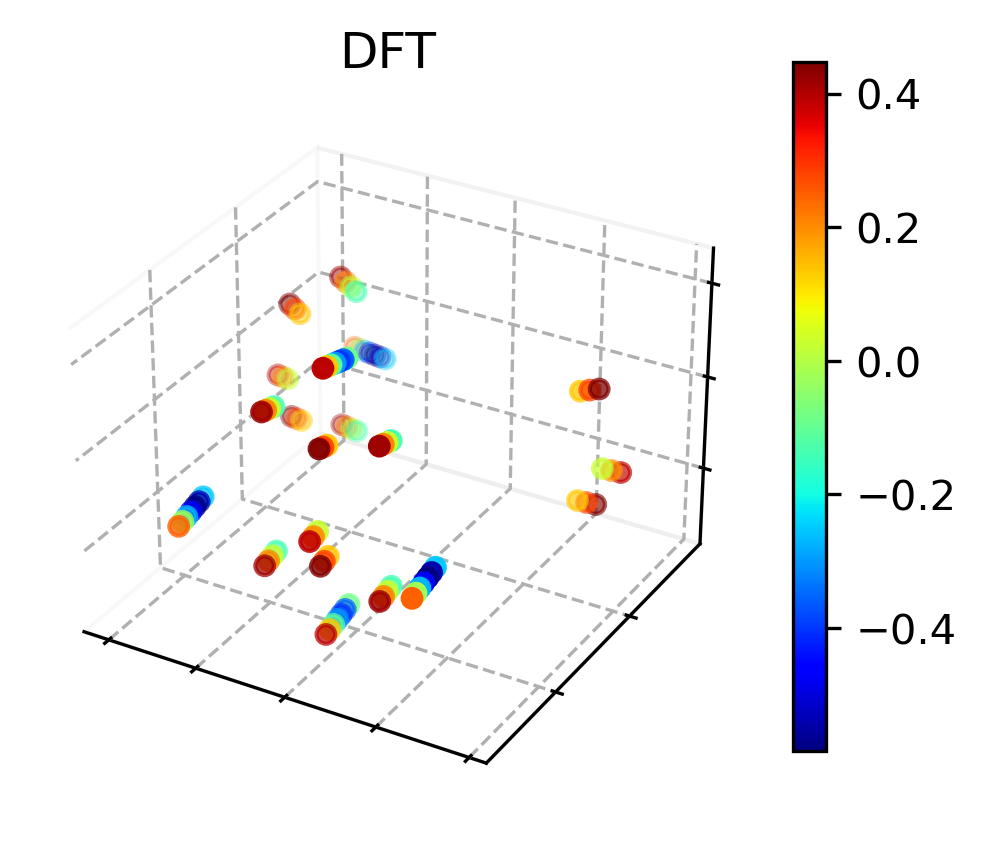

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_DFT(HCoord, HEnergy):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('DFT')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_DFT.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_DFT.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_DFT(HCoordl, HEnergy)


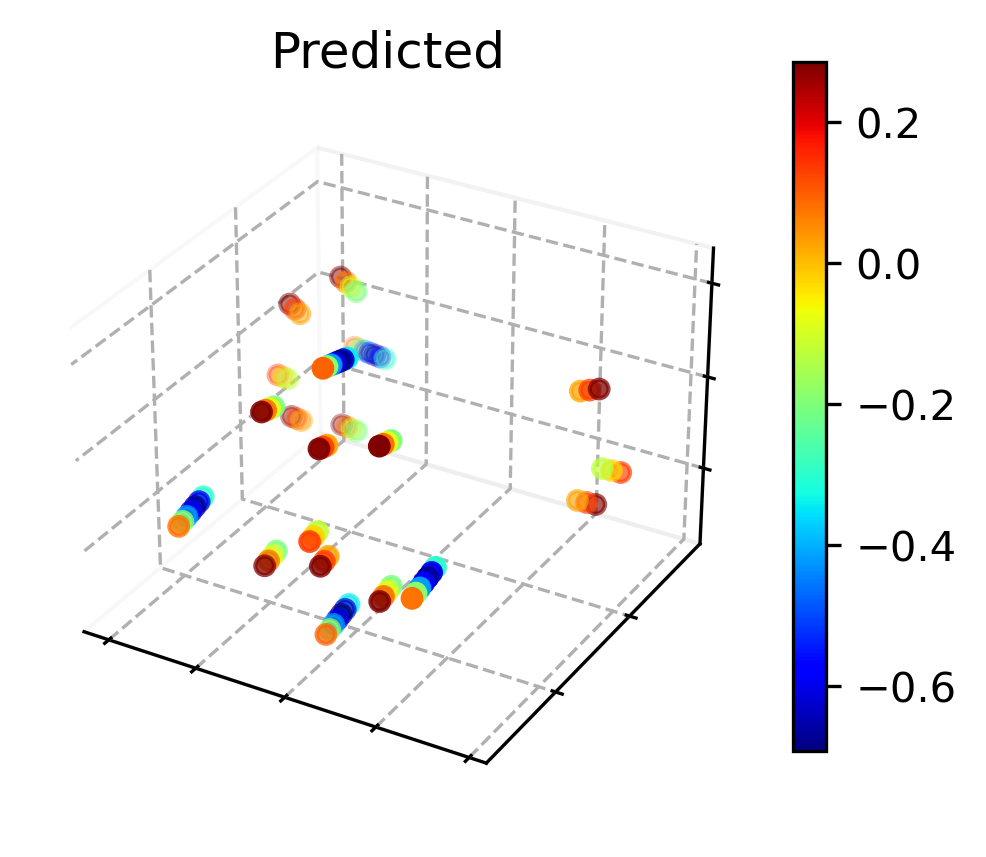

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Pred(HCoord, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Predicted')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_Pred.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_Pred.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_Pred(HCoordl, HEnergy_pred)


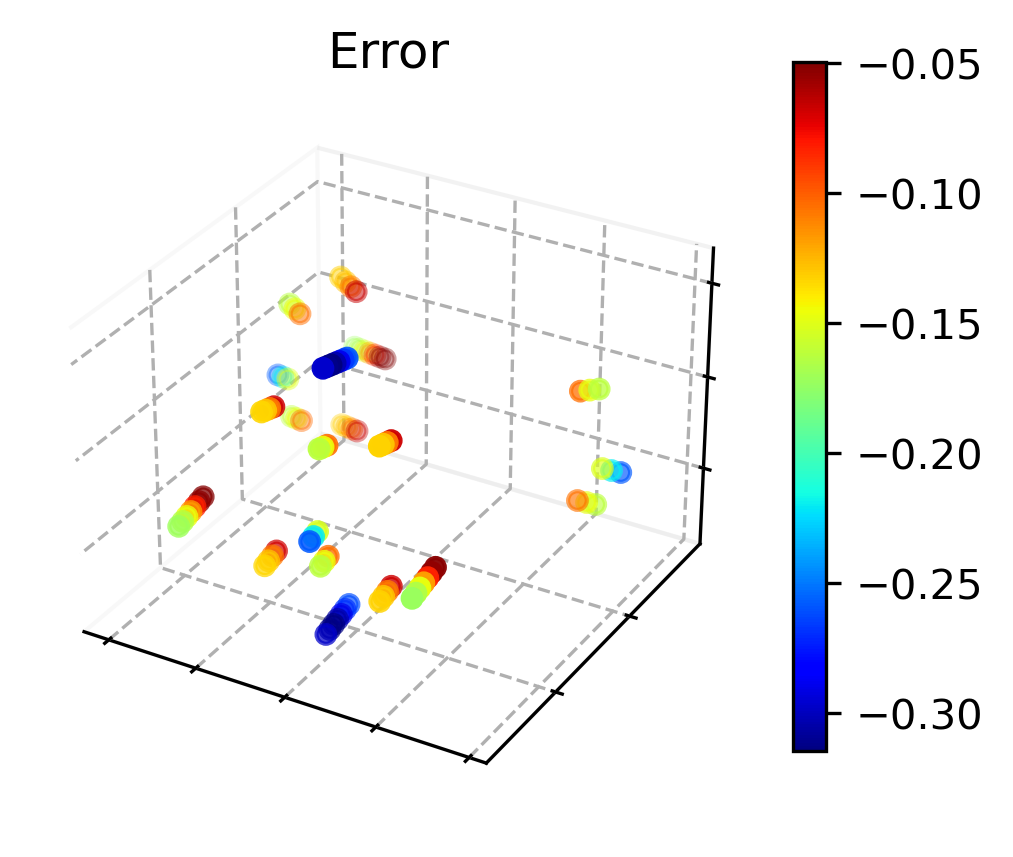

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Error(HCoord, HEnergy_difference):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=dpi)

    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Error')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_difference, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_Error.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt5_Error.svg",dpi=300, bbox_inches='tight')

    plt.show()


plot_3d_scatter_Error(HCoordl, HEnergy_difference)


##### pt43

In [1]:
import numpy as np
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import MES
import joblib

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["Pt43"]

data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
HCoord = [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster]
HEnergy = energy_ptcluster

# Calculate SOAP descriptors
soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
Eigenvector = Eigenvector[:, 0, :]
#Predict other sets
pending_Eigenvector = Eigenvector
pending_atoms = atoms_ptcluster
pending_energy = energy_ptcluster
pending_min_distance = np.array([MES(pending_atoms[i])['min_distance'] for i in range(len(pending_atoms))])
pending_radius = np.array([MES(pending_atoms[i])['radius'] for i in range(len(pending_atoms))]) 
# Define different basis sets
soap_dPt_H_S_r_other = np.concatenate((np.concatenate((pending_Eigenvector, pending_min_distance.reshape(-1, 1)), axis=1), pending_radius.reshape(-1, 1)), axis=1)


def predict_HEnergy(soap_dPt_H_S_r_other):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    HEnergy_pred = GPRP.predict(soap_dPt_H_S_r_other)
    return HEnergy_pred

HEnergy_pred = predict_HEnergy(soap_dPt_H_S_r_other)
HCoordl = np.array([coord[0] for coord in HCoord])
HEnergy_difference = HEnergy_pred - HEnergy

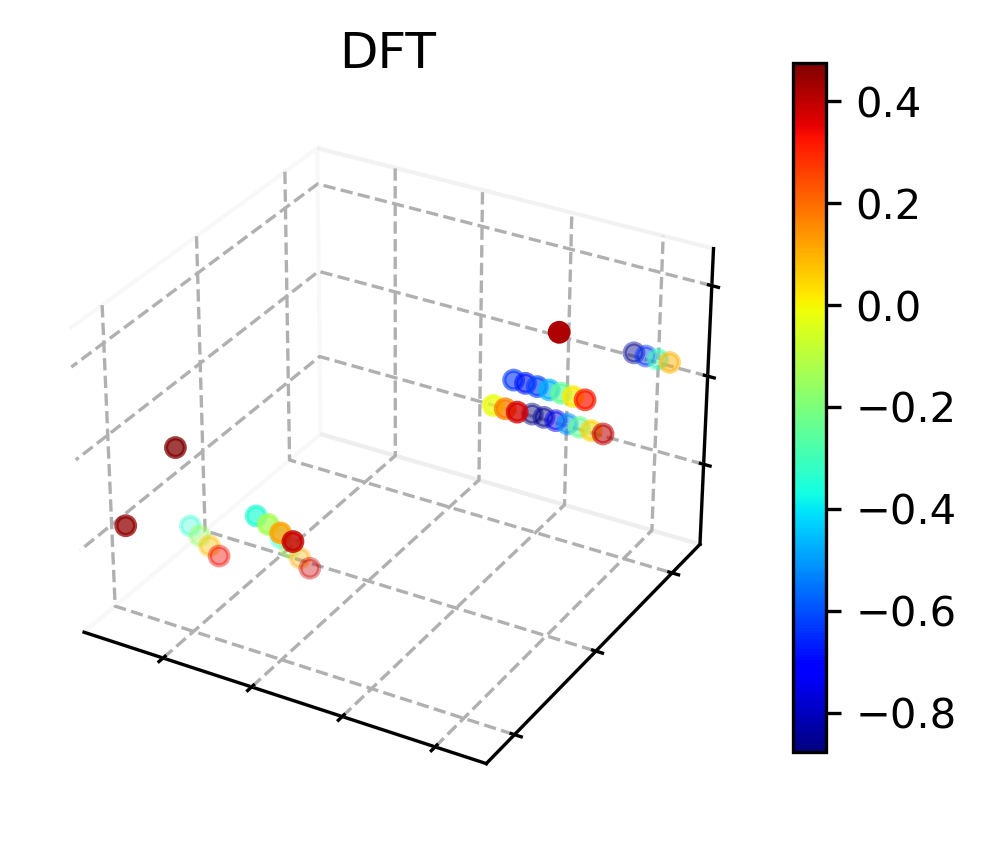

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_DFT(HCoord, HEnergy):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('DFT')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_DFT.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_DFT.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_DFT(HCoordl, HEnergy)


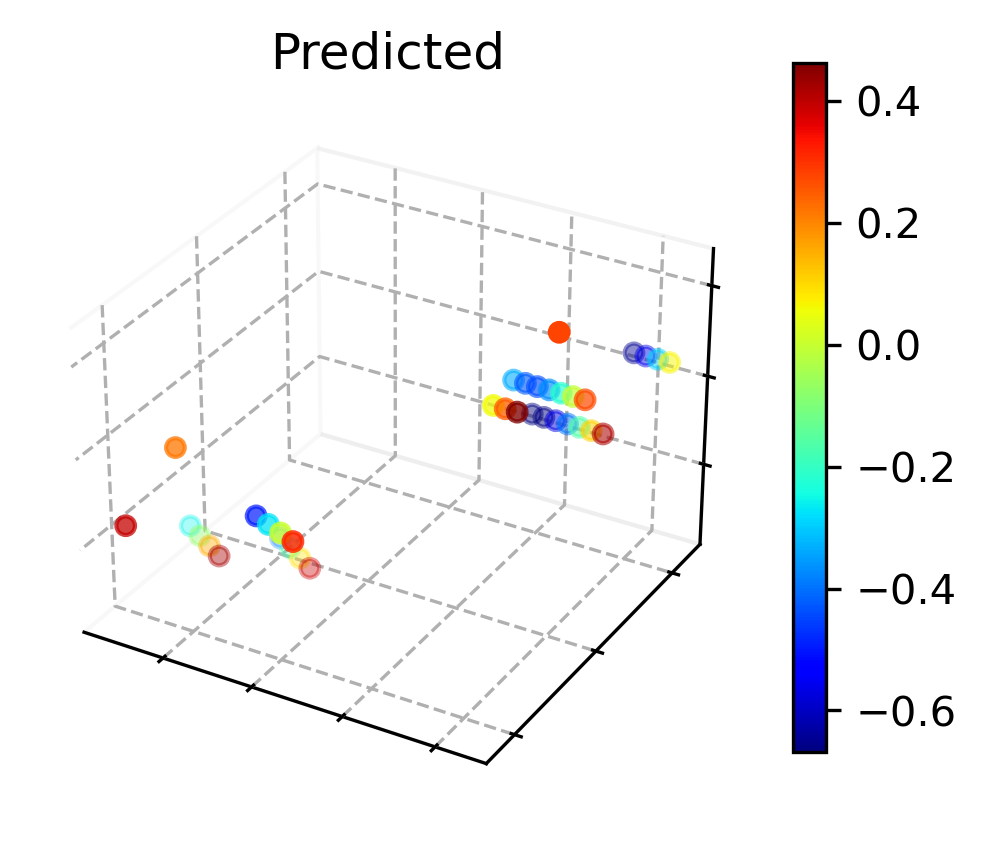

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Pred(HCoord, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Predicted')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_Pred.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_Pred.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_Pred(HCoordl, HEnergy_pred)


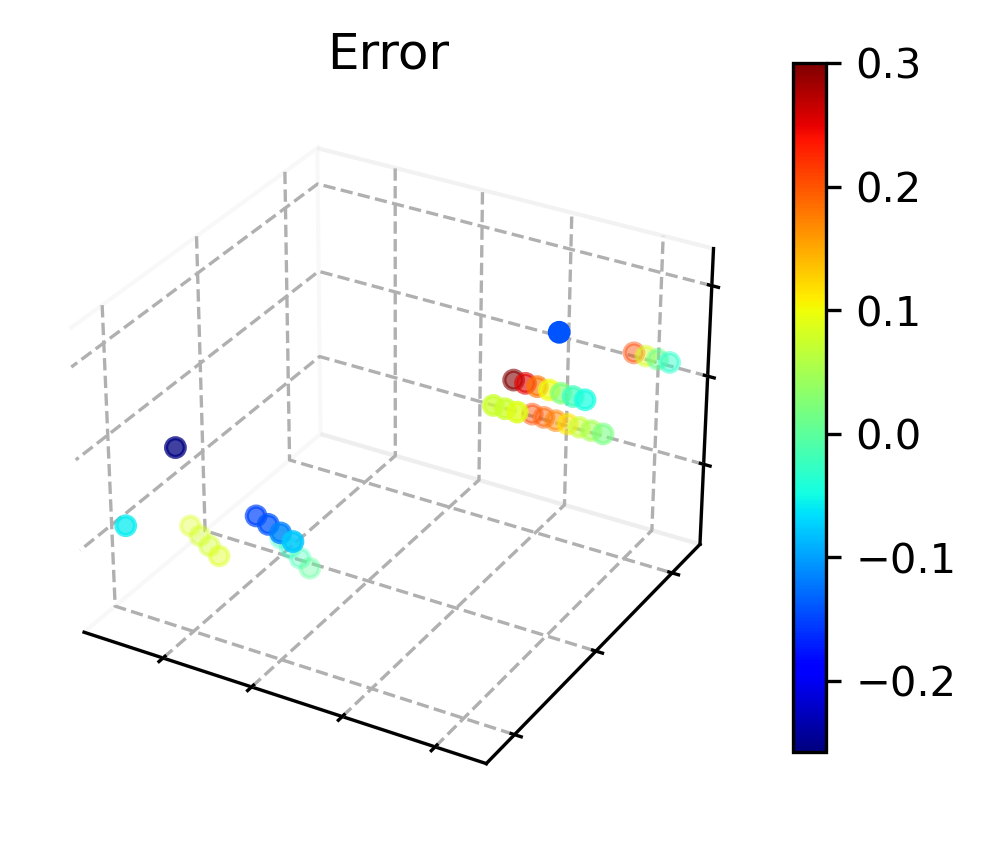

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Error(HCoord, HEnergy_difference):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=dpi)

    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Error')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_difference, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_Error.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt43_Error.svg",dpi=300, bbox_inches='tight')

    plt.show()


plot_3d_scatter_Error(HCoordl, HEnergy_difference)


##### pt11

In [1]:
import numpy as np
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import MES
import joblib

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt11"]

data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
HCoord = [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster]
HEnergy = energy_ptcluster

# Calculate SOAP descriptors
soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
Eigenvector = Eigenvector[:, 0, :]
#Predict other sets
pending_Eigenvector = Eigenvector
pending_atoms = atoms_ptcluster
pending_energy = energy_ptcluster
pending_min_distance = np.array([MES(pending_atoms[i])['min_distance'] for i in range(len(pending_atoms))])
pending_radius = np.array([MES(pending_atoms[i])['radius'] for i in range(len(pending_atoms))]) 
# Define different basis sets
soap_dPt_H_S_r_other = np.concatenate((np.concatenate((pending_Eigenvector, pending_min_distance.reshape(-1, 1)), axis=1), pending_radius.reshape(-1, 1)), axis=1)


def predict_HEnergy(soap_dPt_H_S_r_other):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    HEnergy_pred = GPRP.predict(soap_dPt_H_S_r_other)
    return HEnergy_pred

HEnergy_pred = predict_HEnergy(soap_dPt_H_S_r_other)
HCoordl = np.array([coord[0] for coord in HCoord])
HEnergy_difference = HEnergy_pred - HEnergy

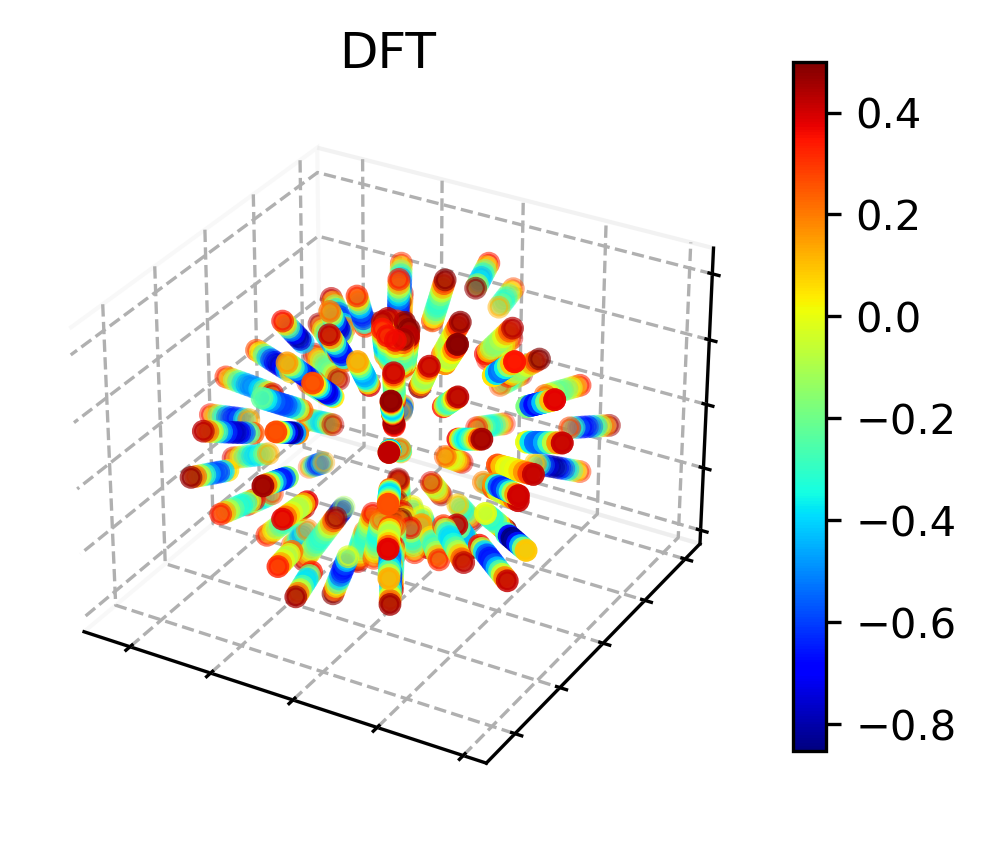

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_DFT(HCoord, HEnergy):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('DFT')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_DFT.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_DFT.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_DFT(HCoordl, HEnergy)


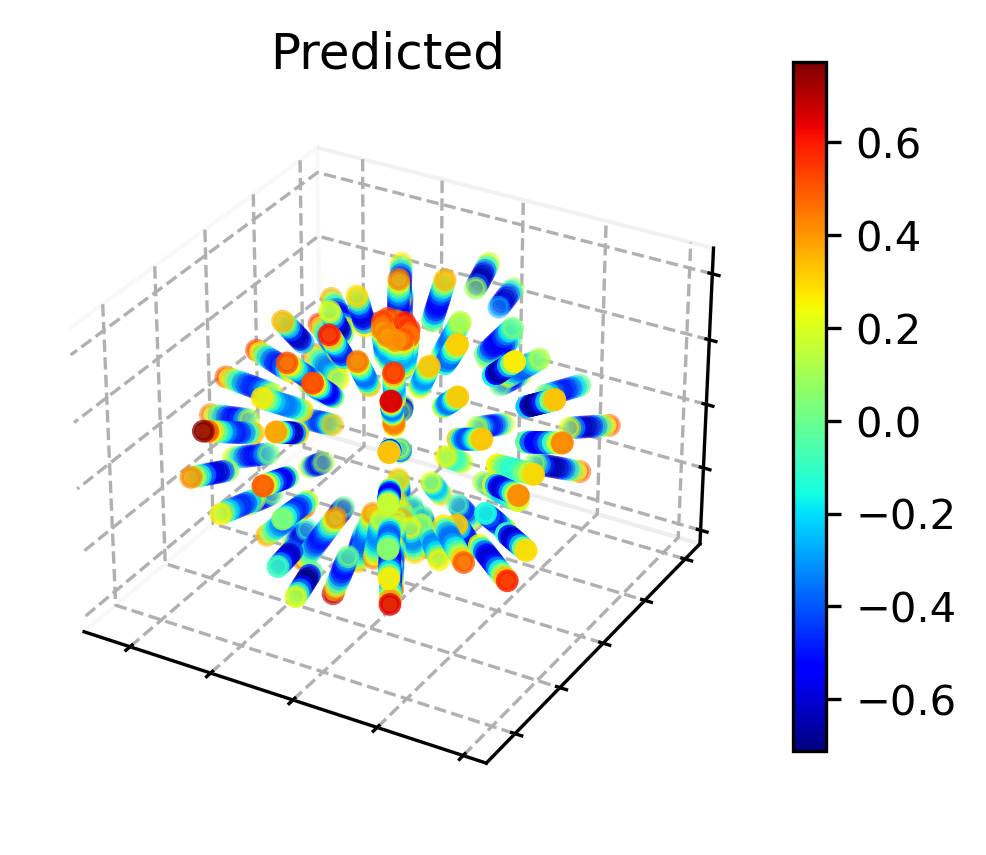

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Pred(HCoord, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Predicted')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_Pred.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_Pred.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_Pred(HCoordl, HEnergy_pred)


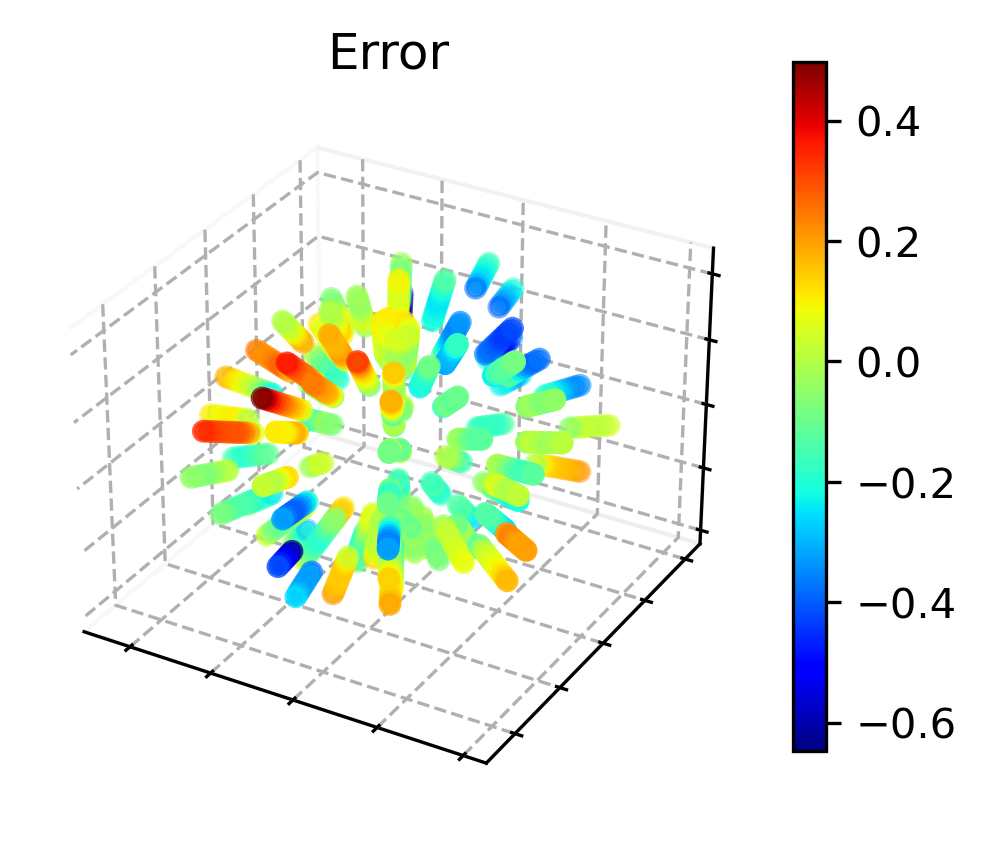

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Error(HCoord, HEnergy_difference):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=dpi)

    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Error')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_difference, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_Error.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt11_Error.svg",dpi=300, bbox_inches='tight')

    plt.show()


plot_3d_scatter_Error(HCoordl, HEnergy_difference)


##### pt23

In [1]:
import numpy as np
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import MES
import joblib

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt23"]

data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
HCoord = [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster]
HEnergy = energy_ptcluster

# Calculate SOAP descriptors
soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
Eigenvector = Eigenvector[:, 0, :]
#Predict other sets
pending_Eigenvector = Eigenvector
pending_atoms = atoms_ptcluster
pending_energy = energy_ptcluster
pending_min_distance = np.array([MES(pending_atoms[i])['min_distance'] for i in range(len(pending_atoms))])
pending_radius = np.array([MES(pending_atoms[i])['radius'] for i in range(len(pending_atoms))]) 
# Define different basis sets
soap_dPt_H_S_r_other = np.concatenate((np.concatenate((pending_Eigenvector, pending_min_distance.reshape(-1, 1)), axis=1), pending_radius.reshape(-1, 1)), axis=1)


def predict_HEnergy(soap_dPt_H_S_r_other):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    HEnergy_pred = GPRP.predict(soap_dPt_H_S_r_other)
    return HEnergy_pred

HEnergy_pred = predict_HEnergy(soap_dPt_H_S_r_other)
HCoordl = np.array([coord[0] for coord in HCoord])
HEnergy_difference = HEnergy_pred - HEnergy

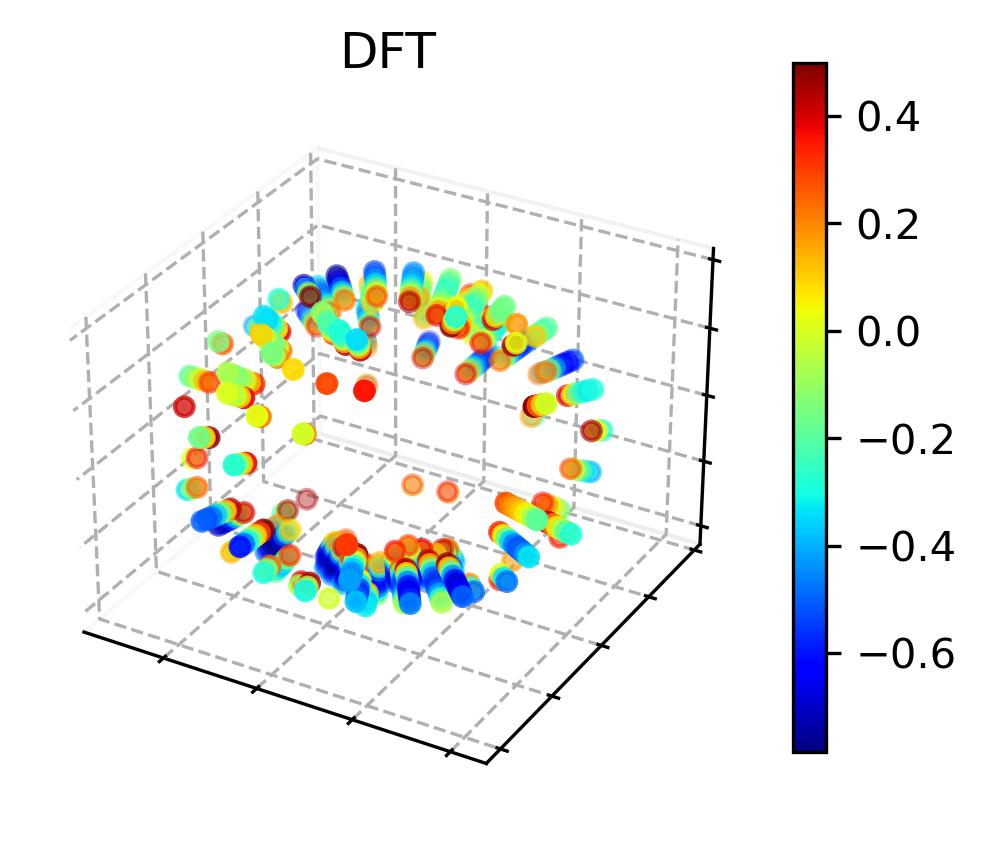

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_DFT(HCoord, HEnergy):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('DFT')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_DFT.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_DFT.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_DFT(HCoordl, HEnergy)


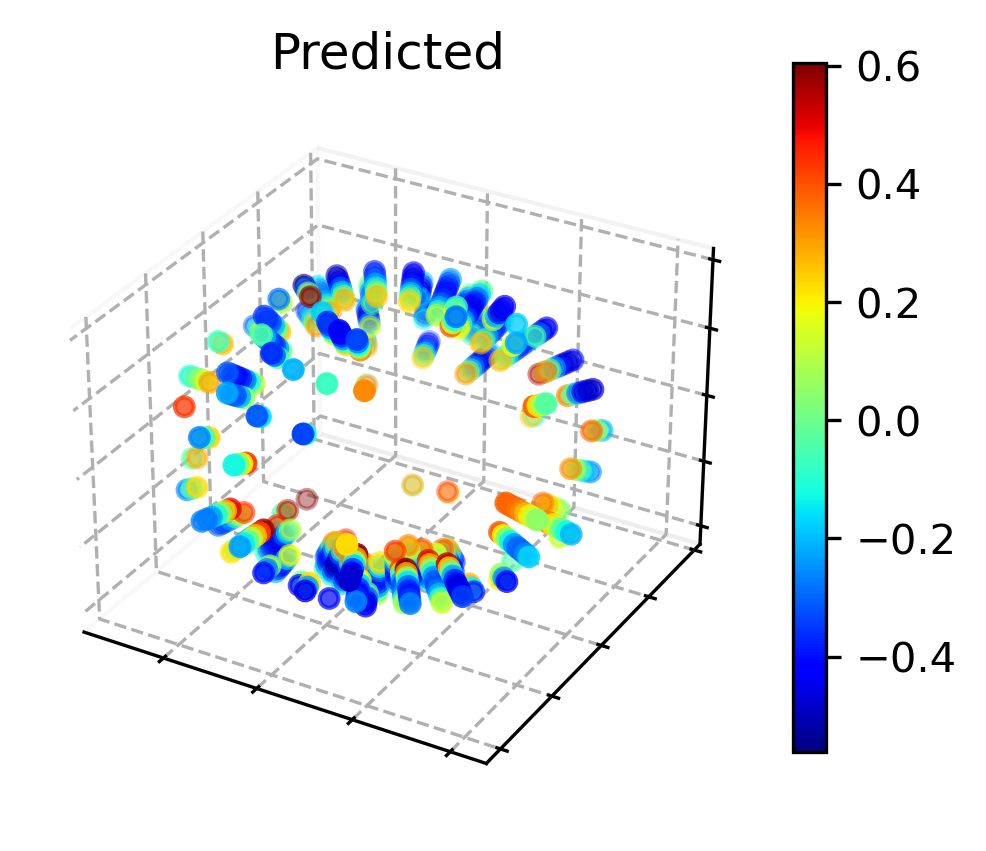

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Pred(HCoord, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Predicted')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_Pred.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_Pred.svg",dpi=300, bbox_inches='tight')

    plt.show()

HCoordl = np.array([coord[0] for coord in HCoord])
plot_3d_scatter_Pred(HCoordl, HEnergy_pred)


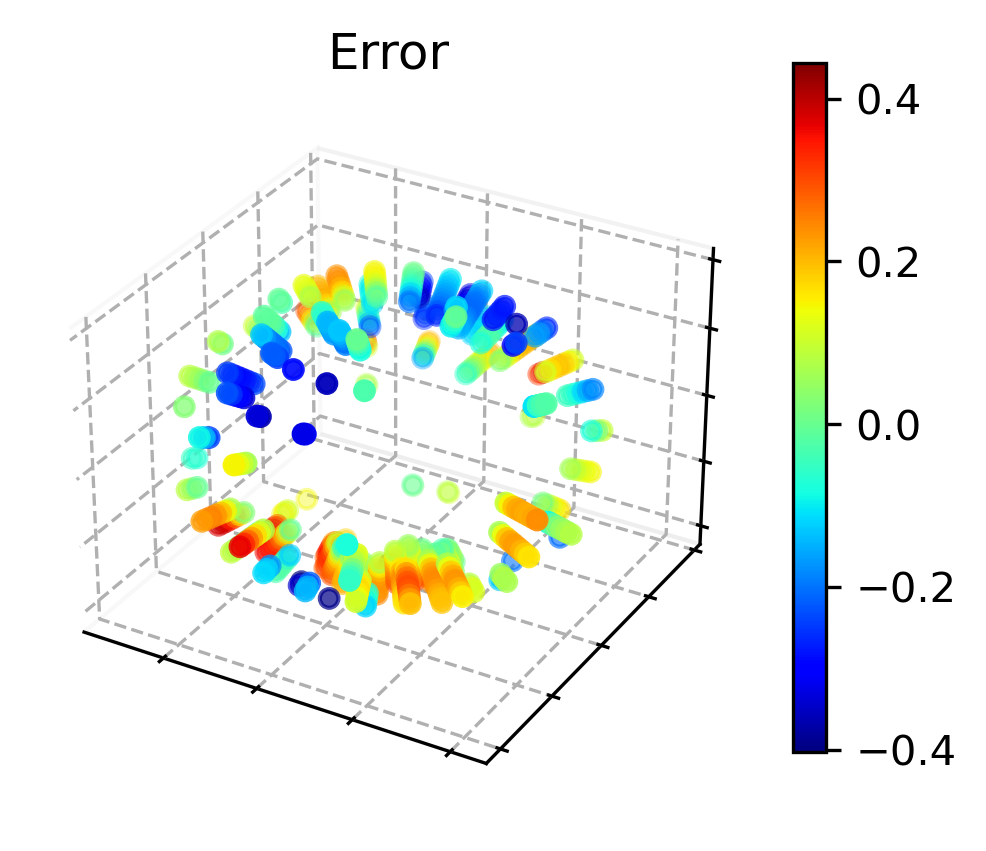

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter_Error(HCoord, HEnergy_difference):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    fig = plt.figure(figsize=(width_inch, height_inch), dpi=dpi)

    ax1 = plt.subplot2grid((18, 20), (0, 0), rowspan=18, colspan=18, projection='3d')
    ax1.set_title('Error')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_difference, cmap='jet')

    ax2 = plt.subplot2grid((18, 20), (0, 19), rowspan=16, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax2)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_Error.tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt23_Error.svg",dpi=300, bbox_inches='tight')

    plt.show()


plot_3d_scatter_Error(HCoordl, HEnergy_difference)


##### 测试代码（非正式） DFT & Predicted pt17

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

def plot_3d_scatter(HCoord, HEnergy, HEnergy_pred):
    """
    绘制三维散点图

    Args:
        HCoord (numpy.ndarray): 坐标数据，形状为(N, 3)
        HEnergy (numpy.ndarray): 真实能量值，形状为(N,)
        HEnergy_pred (numpy.ndarray): 预测能量值，形状为(N,)
    """
    width_mm = 174  # 宽度174mm
    height_mm = 174  # 高度174mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    
    ax1 = plt.subplot2grid((8, 20), (0, 0), rowspan=8, colspan=8, projection='3d')
    ax1.set_title('Calculated')
    # 设置网格线为虚线
    ax1.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_zticklabels([])
    ax1.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax1.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax1.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc1 = ax1.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy, cmap='jet')
    
    ax2 = plt.subplot2grid((8, 20), (0, 9), rowspan=8, colspan=8, projection='3d')
    ax2.set_title('Predicted')
    # 设置网格线为虚线
    ax2.xaxis._axinfo["grid"]['linestyle'] = "--"
    ax2.yaxis._axinfo["grid"]['linestyle'] = "--"
    ax2.zaxis._axinfo["grid"]['linestyle'] = "--"
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_zticklabels([])
    ax2.xaxis.pane.fill = False  # 设置x轴平面填充为False
    ax2.yaxis.pane.fill = False  # 设置y轴平面填充为False
    ax2.zaxis.pane.fill = False  # 设置z轴平面填充为False
    sc2 = ax2.scatter(HCoord[:, 0], HCoord[:, 1], HCoord[:, 2], c=HEnergy_pred, cmap='jet')

    ax3 = plt.subplot2grid((8, 20), (2, 19), rowspan=4, colspan=1)
    cb1 = plt.colorbar(sc1, cax=ax3)
    cb1.set_label('Energy(eV)')
    plt.tight_layout()
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17.tif",dpi=300, bbox_inches='tight')
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/ML_GPR_soap_dpth_sr_pt17.svg",dpi=300, bbox_inches='tight')

    plt.show()

plot_3d_scatter(HCoordl, HEnergy, HEnergy_pred)


### 草稿

In [ ]:
import random
other_index = random.sample(range(1, 6001), 100)
print(other_index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import random

def plot_results(y_train, ML_x_train_pred, y_test, ML_x_test_pred, ML_train_MAE, ML_train_R2, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_train = ax3.scatter(y_train, ML_x_train_pred, marker='>', c='k', s=1, label="Train data")
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    plt.legend((ML_train, ML_test),
               ("Train: {}, {}".format("MAE = {:.4f}".format(ML_train_MAE),
                                          "$R^2$ = {:.4f}".format(ML_train_R2)),
                "Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),
                                      "$R^2$ = {:.4f}".format(ML_test_R2))),
               loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    #plt.savefig("/home/yzh/Mywork/Myresult/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    #plt.savefig("/home/yzh/Mywork/Myresult/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()

def calculate_RFR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, model_name, figname):
    RFR = RandomForestRegressor(n_estimators=100, random_state=10)
    X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
    X_train = soap_dPt_H_S_r
    y_train = basis_energy
    X_test = soap_dPt_H_S_r_other
    y_test = other_energy
    RFR.fit(X_train, y_train)
    RFR_x_train_pred = RFR.predict(X_train)
    RFR_x_test_pred = RFR.predict(X_test)
    RFR_train_MAE = mean_absolute_error(y_train, RFR_x_train_pred)
    RFR_train_R2 = r2_score(y_train, RFR_x_train_pred)
    RFR_test_MAE = mean_absolute_error(y_test, RFR_x_test_pred)
    RFR_test_R2 = r2_score(y_test, RFR_x_test_pred)
    RFR_test_RMSE = np.sqrt(mean_squared_error(y_test, RFR_x_test_pred))
    print("RFR_test_MAE:",RFR_test_MAE)
    print("RFR_test_RMSE:",RFR_test_RMSE)
    print("RFR_test_R2:",RFR_test_R2)
    plot_results(y_train, RFR_x_train_pred, y_test, RFR_x_test_pred, RFR_train_MAE, RFR_train_R2, RFR_test_MAE, RFR_test_R2, model_name, figname)

# Rest of the code for data loading and SOAP calculation remains the same
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Mycode.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    #Predict other sets
    other_index = random.sample(range(1, 6001), 100)
    other_Eigenvector = Eigenvector[other_index]
    other_atoms = atoms_ptcluster[other_index]
    other_energy = energy_ptcluster[other_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    other_min_distance = np.array([MES(other_atoms[i])['min_distance'] for i in range(len(other_atoms))])
    other_radius = np.array([MES(other_atoms[i])['radius'] for i in range(len(other_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_min_distance.reshape(-1, 1)), axis=1), basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H_S_r_other = np.concatenate((np.concatenate((other_Eigenvector, other_min_distance.reshape(-1, 1)), axis=1), other_radius.reshape(-1, 1)), axis=1)
   
    calculate_RFR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, 'RFR', 'RFR_predict the energy')
    return

# Example
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


def plot_results(y_test, ML_x_test_pred, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    ax3.legend(handles=[ML_test], labels=["{}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2))], loc='upper left', prop={'size': 5})
    #plt.legend(ML_test,"Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2)),loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()

def calculate_RFR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, model_name, figname):
    RFR = RandomForestRegressor(n_estimators=100, random_state=10)
    X_train, X_test, y_train, y_test = train_test_split(soap_dPt_H_S_r, basis_energy, test_size=0.4, random_state=10)
    RFR.fit(X_train, y_train)
    joblib.dump(RFR, "/home/zhihengyu/WORK/Result/Model/MLRFR_soap-dpth-sr.pkl")
    predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname)

def predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname):
    RFRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLRFR_soap-dpth-sr.pkl")
    X_test = soap_dPt_H_S_r_other
    y_test = other_energy
    
    RFR_x_test_pred = RFRP.predict(X_test)
    RFR_test_MAE = mean_absolute_error(y_test, RFR_x_test_pred)
    RFR_test_R2 = r2_score(y_test, RFR_x_test_pred)
    RFR_test_RMSE = np.sqrt(mean_squared_error(y_test, RFR_x_test_pred))
    print("RFR_test_MAE:",RFR_test_MAE)
    print("RFR_test_RMSE:",RFR_test_RMSE)
    print("RFR_test_R2:",RFR_test_R2)
    plot_results(y_test, RFR_x_test_pred, RFR_test_MAE, RFR_test_R2, model_name, figname)

# Rest of the code for data loading and SOAP calculation remains the same
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index):
    from dscribe.descriptors import SOAP
    from Code.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Code.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    #Predict other sets
    other_Eigenvector = Eigenvector[other_index]
    other_atoms = atoms_ptcluster[other_index]
    other_energy = energy_ptcluster[other_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    other_min_distance = np.array([MES(other_atoms[i])['min_distance'] for i in range(len(other_atoms))])
    other_radius = np.array([MES(other_atoms[i])['radius'] for i in range(len(other_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_min_distance.reshape(-1, 1)), axis=1), basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H_S_r_other = np.concatenate((np.concatenate((other_Eigenvector, other_min_distance.reshape(-1, 1)), axis=1), other_radius.reshape(-1, 1)), axis=1)
   
    calculate_RFR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, 'RFR', 'RFR_predict the energy')
    return

# Example
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index)


In [ ]:
import random

# 生成包含100个随机数的数组
random_numbers = random.sample(range(1, 6001), 100)

# 输出随机数数组
print(random_numbers)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import random

other_index = random.sample(range(1, 6001), 100)
print(other_index)

def plot_results(y_test, ML_x_test_pred, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    ax3.legend(handles=[ML_test], labels=["{}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2))], loc='upper left', prop={'size': 5})
    #plt.legend(ML_test,"Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2)),loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()

def calculate_GPR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, model_name, figname):
    kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e6))
    GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    X_train, X_test, y_train, y_test = train_test_split(soap_dPt_H_S_r, basis_energy, test_size=0.4, random_state=10)
    GPR.fit(X_train, y_train)
    joblib.dump(GPR, "/home/zhihengyu/WORK/Result/Model/MLGPR_soap-dpth-sr.pkl")
    predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname)

def predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_soap-dpth-sr.pkl")
    X_test = soap_dPt_H_S_r_other
    y_test = other_energy
    
    GPR_x_test_pred = GPRP.predict(X_test)
    GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
    GPR_test_R2 = r2_score(y_test, GPR_x_test_pred)
    GPR_test_RMSE = np.sqrt(mean_squared_error(y_test, GPR_x_test_pred))
    print("GPR_test_MAE:",GPR_test_MAE)
    print("GPR_test_RMSE:",GPR_test_RMSE)
    print("GPR_test_R2:",GPR_test_R2)
    plot_results(y_test, GPR_x_test_pred, GPR_test_MAE, GPR_test_R2, model_name, figname)

# Rest of the code for data loading and SOAP calculation remains the same
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index):
    from dscribe.descriptors import SOAP
    from Code.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Code.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    #Predict other sets
    other_Eigenvector = Eigenvector[other_index]
    other_atoms = atoms_ptcluster[other_index]
    other_energy = energy_ptcluster[other_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    other_min_distance = np.array([MES(other_atoms[i])['min_distance'] for i in range(len(other_atoms))])
    other_radius = np.array([MES(other_atoms[i])['radius'] for i in range(len(other_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_min_distance.reshape(-1, 1)), axis=1), basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H_S_r_other = np.concatenate((np.concatenate((other_Eigenvector, other_min_distance.reshape(-1, 1)), axis=1), other_radius.reshape(-1, 1)), axis=1)
   
    calculate_GPR(soap_dPt_H_S_r, basis_energy, soap_dPt_H_S_r_other, other_energy, 'GPR', 'GPR_predict the energy')
    return

# Example
import sys
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from sklearn.model_selection import KFold

def plot_results(y_train, ML_x_train_pred, y_test, ML_x_test_pred, ML_train_MAE, ML_train_R2, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_train = ax3.scatter(y_train, ML_x_train_pred, marker='>', c='k', s=1, label="Train data")
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    plt.legend((ML_train, ML_test),
               ("Train: {}, {}".format("MAE = {:.4f}".format(ML_train_MAE),
                                          "$R^2$ = {:.4f}".format(ML_train_R2)),
                "Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),
                                      "$R^2$ = {:.4f}".format(ML_test_R2))),
               loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    #plt.savefig("/home/yzh/Mywork/Myresult/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    #plt.savefig("/home/yzh/Mywork/Myresult/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()

def calculate_GPR(X, y, model_name, figname, nfold=5):
    GPR_best_MAE = float('inf')
    GPR_best_model = None
    kernel = ConstantKernel() * RBF(length_scale_bounds=(1e-6, 1e6))
    GPR = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    kf = KFold(n_splits=nfold, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        GPR.fit(X_train, y_train)
        GPR_x_train_pred = GPR.predict(X_train)
        GPR_x_test_pred = GPR.predict(X_test)
        GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
        if GPR_test_MAE < GPR_best_MAE:
            GPR_best_MAE = GPR_test_MAE
            GPR_best_model = GPR
    GPR_x_train_pred = GPR_best_model.predict(X_train)
    GPR_x_test_pred = GPR_best_model.predict(X_test)
    GPR_train_MAE = mean_absolute_error(y_train, GPR_x_train_pred)
    GPR_train_R2 = r2_score(y_train, GPR_x_train_pred)
    GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
    GPR_test_R2 = r2_score(y_test, GPR_x_test_pred)
    GPR_test_RMSE = np.sqrt(mean_squared_error(y_test, GPR_x_test_pred))
    print("Best GPR Model:",GPR_best_model)
    print("GPR_test_MAE:", GPR_test_MAE)
    print("GPR_test_RMSE:", GPR_test_RMSE)
    print("GPR_test_R2:", GPR_test_R2)
    plot_results(y_train, GPR_x_train_pred, y_test, GPR_x_test_pred, GPR_train_MAE, GPR_train_R2, GPR_test_MAE, GPR_test_R2, model_name, figname)

def calculate_RFR(X, y, model_name, figname, nfold=5):
    RFR_best_MAE = float('inf')
    RFR_best_model = None
    RFR = RandomForestRegressor(n_estimators=100, random_state=10)
    kf = KFold(n_splits=nfold, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        RFR.fit(X_train, y_train)
        RFR_x_train_pred = RFR.predict(X_train)
        RFR_x_test_pred = RFR.predict(X_test)
        RFR_test_MAE = mean_absolute_error(y_test, RFR_x_test_pred)
        if RFR_test_MAE < RFR_best_MAE:
            RFR_best_MAE = RFR_test_MAE
            RFR_best_model = RFR
    RFR_x_train_pred = RFR_best_model.predict(X_train)
    RFR_x_test_pred = RFR_best_model.predict(X_test)
    RFR_train_MAE = mean_absolute_error(y_train, RFR_x_train_pred)
    RFR_train_R2 = r2_score(y_train, RFR_x_train_pred)
    RFR_test_MAE = mean_absolute_error(y_test, RFR_x_test_pred)
    RFR_test_R2 = r2_score(y_test, RFR_x_test_pred)
    RFR_test_RMSE = np.sqrt(mean_squared_error(y_test, RFR_x_test_pred))
    print("Best RFR Model:",RFR_best_model)
    print("RFR_test_MAE:",RFR_test_MAE)
    print("RFR_test_RMSE:",RFR_test_RMSE)
    print("RFR_test_R2:",RFR_test_R2)
    plot_results(y_train, RFR_x_train_pred, y_test, RFR_x_test_pred, RFR_train_MAE, RFR_train_R2, RFR_test_MAE, RFR_test_R2, model_name, figname)

# Rest of the code for data loading and SOAP calculation remains the same
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Mycode.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap = basis_Eigenvector
    soap_S_r = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)
    basis_sets = [soap, soap_S_r, soap_dPt_H, soap_dPt_H_S_r]
    
    # Train and test for different basis sets
    for i, basis_set in enumerate(basis_sets):
        X = basis_set
        y = basis_energy
        calculate_GPR(X, y, 'GPR', 'GPR_'+str(i))
        calculate_RFR(X, y, 'RFR', 'RFR_'+str(i))
    return

# Example
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)


In [ ]:
#用已训练所得的model预测
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/zhihengyu/WORK/')
from Code.Bin.Calculate import extract_data_pro
from dscribe.descriptors import SOAP
from Code.Bin.Calculate import get_basis_sets_by_KMeans
from Code.Bin.Calculate import MES

import random
other_index = random.sample(range(1, 6001), 1000)
print(other_index)

def plot_results(y_test, ML_x_test_pred, ML_test_MAE, ML_test_R2, model_name, figname):
    width_mm = 87  # 宽度87mm
    height_mm = 87  # 高度87mm
    width_inch = width_mm / 25.4
    height_inch = height_mm / 25.4
    dpi = 300  # 每英寸300像素
    plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
    [min_val, max_val] = [-1.25, 0.75]
    # subplot(2,2,1)
    ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
    ax1.hist(y_test, bins=50, alpha=1, color='k')
    plt.xlim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    # subplot(2,2,4)
    ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
    ax2.hist(ML_x_test_pred, bins=50, orientation='horizontal', alpha=1, color='r')
    plt.ylim((min_val, max_val))
    plt.xticks([])
    plt.yticks([])
    
    # subplot(2,2,3)
    ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
    ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=1, label="Test data")
    
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
    plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 6}, labelpad=0)
    plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 6}, labelpad=0)
    ax3.legend(handles=[ML_test], labels=["{}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2))], loc='upper left', prop={'size': 5})
    #plt.legend(ML_test,"Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),"$R^2$ = {:.4f}".format(ML_test_R2)),loc='upper left', prop={'size': 5})
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".tif",dpi=300, bbox_inches='tight')
    #plt.savefig("/home/zhihengyu/WORK/Result/Picture/" + figname + ".svg",dpi=300, bbox_inches='tight')
    # 显示图像
    plt.show()
    
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index, model_name, figname):
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    #Predict other sets
    other_Eigenvector = Eigenvector[other_index]
    other_atoms = atoms_ptcluster[other_index]
    other_energy = energy_ptcluster[other_index]

    other_min_distance = np.array([MES(other_atoms[i])['min_distance'] for i in range(len(other_atoms))])
    other_radius = np.array([MES(other_atoms[i])['radius'] for i in range(len(other_atoms))])
    
    # Define different basis sets
    soap_dPt_H_S_r_other = np.concatenate((np.concatenate((other_Eigenvector, other_min_distance.reshape(-1, 1)), axis=1), other_radius.reshape(-1, 1)), axis=1)
    predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname)
    return

def predict_other(soap_dPt_H_S_r_other, other_energy, model_name, figname):
    GPRP = joblib.load("/home/zhihengyu/WORK/Result/Model/MLGPR_P_soap-dpth-sr.pkl")
    X_test = soap_dPt_H_S_r_other
    y_test = other_energy
    
    GPRP_x_test_pred = GPRP.predict(X_test)
    GPRP_test_MAE = mean_absolute_error(y_test, GPRP_x_test_pred)
    GPRP_test_R2 = r2_score(y_test, GPRP_x_test_pred)
    GPRP_test_RMSE = np.sqrt(mean_squared_error(y_test, GPRP_x_test_pred))
    print("GPRP_test_MAE:",GPRP_test_MAE)
    print("GPRP_test_RMSE:",GPRP_test_RMSE)
    print("GPRP_test_R2:",GPRP_test_R2)
    plot_results(y_test, GPRP_x_test_pred, GPRP_test_MAE, GPRP_test_R2, model_name, figname)

adsorption_data_dir = "/home/zhihengyu/WORK/Data/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, other_index, 'GPR', 'MLGPR_P')


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

def calculate_GBR(X_train, X_test, y_train, y_test, model_name, figname):
    GBR = GradientBoostingRegressor()
    GBR.fit(X_train, y_train)
    GBR_x_train_pred = GBR.predict(X_train)
    GBR_x_test_pred = GBR.predict(X_test)
    GBR_train_MAE = mean_absolute_error(y_train, GBR_x_train_pred)
    GBR_train_R2 = r2_score(y_train, GBR_x_train_pred)
    GBR_test_MAE = mean_absolute_error(y_test, GBR_x_test_pred)
    GBR_test_R2 = r2_score(y_test, GBR_x_test_pred)
    GBR_test_RMSE = np.sqrt(mean_squared_error(y_test, GBR_x_test_pred))
    print("GBR_test_MAE:", GBR_test_MAE)
    print("GBR_test_RMSE:", GBR_test_RMSE)
    print("GBR_test_R2:", GBR_test_R2)
    plot_results(y_train, GBR_x_train_pred, y_test, GBR_x_test_pred, GBR_train_MAE, GBR_train_R2, GBR_test_MAE, GBR_test_R2, model_name, figname)

def calculate_XGB(X_train, X_test, y_train, y_test, model_name, figname):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    params = {'max_depth': 1, 'eta': 0.1, 'objective': 'reg:squarederror'}
    num_round = 1000
    XGB = xgb.train(params, dtrain, num_round, verbose_eval=False)
    XGB_x_train_pred = XGB.predict(dtrain)
    XGB_x_test_pred = XGB.predict(dtest)
    XGB_train_MAE = mean_absolute_error(y_train, XGB_x_train_pred)
    XGB_train_R2 = r2_score(y_train, XGB_x_train_pred)
    XGB_test_MAE = mean_absolute_error(y_test, XGB_x_test_pred)
    XGB_test_R2 = r2_score(y_test, XGB_x_test_pred)
    XGB_test_RMSE = np.sqrt(mean_squared_error(y_test, XGB_x_test_pred))
    print("XGB_test_MAE:", XGB_test_MAE)
    print("XGB_test_RMSE:", XGB_test_RMSE)
    print("XGB_test_R2:", XGB_test_R2)
    plot_results(y_train, XGB_x_train_pred, y_test, XGB_x_test_pred, XGB_train_MAE, XGB_train_R2, XGB_test_MAE, XGB_test_R2, model_name, figname)
#XGB过拟合
    
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from Mycode.Bin.Calculate import MES
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    soap = basis_Eigenvector
    soap_S_r = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    soap_dPt_H = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    soap_dPt_H_S_r = np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)
    basis_sets = [soap, soap_S_r, soap_dPt_H, soap_dPt_H_S_r]
     
    # Train and test for different basis sets
    for i, basis_set in enumerate(basis_sets):
        X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
        #calculate_GPR(X_train, X_test, y_train, y_test, 'GPR', 'GPR_'+str(i))
        #calculate_RFR(X_train, X_test, y_train, y_test, 'RFR', 'RFR_'+str(i))
        #calculate_SVM(X_train, X_test, y_train, y_test, 'SVM', 'SVM_'+str(i))
        #calculate_GBR(X_train, X_test, y_train, y_test, 'GBR', 'GBR_'+str(i))
        calculate_XGB(X_train, X_test, y_train, y_test, 'XGB', 'XGB_'+str(i))
    return


# Example
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data_pro
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']

calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)


In [ ]:
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data_pro
import numpy as np
from ase.visualize.plot import plot_atoms
from Mycode.Bin.Calculate import MES
adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data_pro(adsorption_data_dir, E0, directory)
atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
atoms_example = atoms_ptcluster[3290]
positions = atoms_example.get_positions()
S_r = np.array([MES(atoms_example)['radius']])
dPt_H = np.array([MES(atoms_example)['min_distance']])

print(positions)
print(S_r)
print(dPt_H)
print(atoms_example)
fig, ax = plt.subplots()
plot_atoms(atoms_example, ax, radii=0.3, rotation=('90x,90y,90z'))
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
descriptors_name = ['SOAP+<dPt-H>+<S-r>', 'SOAP+<dPt-H>', 'SOAP+<S-r>', 'SOAP']
values1 = [0.7185, 0.7242, 0.6760, 0.6434]
values2 = [0.6871, 0.6747, 0.6312, 0.6208]

# 绘图
width_mm = 174  # 宽度80mm
height_mm = 87  # 高度30mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)

bar_width = 0.35
index = np.arange(len(descriptors_name))

bar1 = ax.barh(index - bar_width/2, values1, bar_width, label='GPR', color='green')
bar2 = ax.barh(index + bar_width/2, values2, bar_width, label='RFR', color='orange')

# 设置标签和标题
ax.set_xlabel('$R^2$_score', fontsize=10)
ax.set_ylabel('Descriptors', fontsize=10)
# 设置x轴刻度范围和间隔
ax.set_xticks(np.arange(0, 1.1, 0.1))
# 设置x轴刻度标签字体大小
ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()], fontsize=8)
# 设置y轴刻度标签字体大小
ax.set_yticks(index)
ax.set_yticklabels(descriptors_name, fontsize=8)
# 调整刻度参数
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

# 显示图例
ax.legend()

# 显示图形
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 6  # x轴刻度标签字体大小
mpl.rcParams['ytick.labelsize'] = 6  # y轴刻度标签字体大小
mpl.rcParams['axes.linewidth'] = 1   # 设置全局框线宽度为1像素


width_mm = 48  # 宽度29mm
height_mm = 66  # 高度30mm
width_inch = width_mm / 25.4   
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, axs = plt.subplots(3, 1, figsize=(width_inch, height_inch), dpi=dpi) # 创建一列三行的子图布局
# 循环绘制三幅图像
for i, e in enumerate([-1, -0.5, 0]):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    print("energy:[%0.2f,%0.2f)" %(e, e+0.5))
    print("num:",len(atoms_ptcluster))

    min_distance = np.array([MES(atoms_ptcluster[i])['min_distance'] for i in range(len(atoms_ptcluster))])
    min_distance = np.round(min_distance, decimals=1)
    
    frequency0 = Counter(min_distance)
    values0 = list(frequency0.keys())
    counts0 = list(frequency0.values())

    # 绘制柱状图
    axs[i].bar(values0, counts0, color=colors[i], width=0.08)
    axs[i].set_xlim(1.2, 2.6)
    axs[i].set_ylim(0, 800)
    # 设置标题
    if i == 0:
        axs[i].set_title('Bond_length', fontsize=8)
    if i == 1:
        axs[i].set_ylabel('Frequency',fontsize=8)
    # 设置 x 轴刻度标签
    if i != 2:
        axs[i].set_xticks([])
    else:
        axs[i].set_xticks([1.2,1.7,2.2,2.6])
        axs[i].set_xlabel('Bonds_length(Å)',fontsize=8)

plt.tight_layout()  # 调整子图布局
#plt.savefig("/home/yzh/Mywork/Myresult/Picture/Distribution_of_Bond_length-Pt_H.tif", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
mpl.rcParams['xtick.labelsize'] = 6  # x轴刻度标签字体大小
mpl.rcParams['ytick.labelsize'] = 6  # y轴刻度标签字体大小
mpl.rcParams['axes.linewidth'] = 1   # 设置全局框线宽度为1像素
# 创建一列三行的子图布局
width_mm = 48  # 宽度80mm
height_mm = 66  # 高度30mm
width_inch = width_mm / 25.4   
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, axs = plt.subplots(3, 1, figsize=(width_inch, height_inch), dpi=dpi)

# 循环绘制三幅图像
for i, e in enumerate([-1, -0.5, 0]):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    print("energy:[%0.2f,%0.2f)" %(e, e+0.5))
    print("num:",len(atoms_ptcluster))

    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    radius = np.round(radius, decimals=1)
    
    frequency1 = Counter(radius)
    values1 = list(frequency1.keys())
    counts1 = list(frequency1.values())

    # 绘制柱状图
    axs[i].bar(values1, counts1, color=colors[i], width=0.08)
    axs[i].set_xlim(1, 10)
    axs[i].set_ylim(0, 300)
    # 设置标题
    if i == 0:
        axs[i].set_title('Size', fontsize=8)
    if i == 1:
        axs[i].set_ylabel('Frequency',fontsize=8)
    # 设置 x 轴刻度标签
    if i != 2:
        axs[i].set_xticks([])
    else:
        axs[i].set_xticks([1,5,9])
        axs[i].set_xlabel('Radius(Å)',fontsize=8)

plt.tight_layout()  # 调整子图布局
#plt.savefig("/home/yzh/Mywork/Myresult/Picture/Distribution_of_Size_radius.tif", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# 数据
descriptors_name = ['SOAP+<dPt-H>+<S-r>', 'SOAP+<dPt-H>', 'SOAP+<S-r>', 'SOAP']
values1 = [0.7185, 0.7242, 0.6760, 0.6434]
values2 = [0.6871, 0.6747, 0.6312, 0.6208]

# 绘图
width_mm = 174  # 宽度80mm
height_mm = 87  # 高度30mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)

ax.barh(descriptors_name, values1, color=['blue', 'red', 'green', 'orange', 'pink', 'grey', 'Magenta'], height = 0.4)
ax.barh(descriptors_name, values2, color=['blue', 'red', 'green', 'orange', 'pink', 'grey', 'Magenta'], height = 0.4)

# 设置标签和标题
ax.set_xlabel('$R^2$_score',fontsize=10)
ax.set_ylabel('Descriptors',fontsize=10)
# 设置x轴刻度范围和间隔
ax.set_xticks(np.arange(0, 1.1, 0.1))
# 设置x轴刻度标签字体大小
ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()], fontsize=8)
# 设置y轴刻度标签字体大小
ax.set_yticks(range(len(descriptors_name)))
ax.set_yticklabels(descriptors_name, fontsize=8)
# 调整刻度参数
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
#plt.savefig("/home/yzh/Mywork/Myresult/Picture/descriptors_contribution.tif", dpi=300, bbox_inches='tight')
# 显示图形
plt.show()

In [ ]:
mpl.rcParams['xtick.labelsize'] = 6  # x轴刻度标签字体大小
mpl.rcParams['ytick.labelsize'] = 6  # y轴刻度标签字体大小
mpl.rcParams['axes.linewidth'] = 1   # 设置全局框线宽度为1像素
# 创建一列三行的子图布局
width_mm = 48  # 宽度80mm
height_mm = 66  # 高度30mm
width_inch = width_mm / 25.4   
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

fig, axs = plt.subplots(3, 1, figsize=(width_inch, height_inch), dpi=dpi)

# 循环绘制三幅图像
for i, e in enumerate([-1, -0.5, 0]):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    print("energy:[%0.2f,%0.2f)" %(e, e+0.5))
    print("num:",len(atoms_ptcluster))

    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    radius = np.round(radius, decimals=1)

    radius_greater_than_5 = radius[radius > 5]  # 仅保留大于5的数据
    print('radius_greater_than_5:',len(radius_greater_than_5))

    frequency1 = Counter(radius_greater_than_5)
    values1 = list(frequency1.keys())
    counts1 = list(frequency1.values())
    
    # 绘制柱状图
    if i == 0:
        ax = axs[2]  # 将第一幅图放在最下方
    if i ==1:
        ax = axs[1]
    if i == 2:
        ax = axs[0]

    # 绘制柱状图
    ax.bar(values1, counts1, color=colors[i], width=0.08)
    ax.set_xlim(5, 10)  # 设置x轴范围为大于5的部分
    ax.set_ylim(0, 10)
    # 设置标题
    if i == 2:
        ax.set_title('Size', fontsize=8)
    if i == 1:
        ax.set_ylabel('Frequency',fontsize=8)
    # 设置 x 轴刻度标签
    if i != 0:
        ax.set_xticks([])
    else:
        ax.set_xticks([5,6,7,8,9,10])  # 设置x轴刻度为大于5的部分
        ax.set_xlabel('Radius(Å)',fontsize=8)

    # 计算大于5的区域所占百分比
    percentage_greater_than_5 = len(radius_greater_than_5) / 6293 * 100
    ax.text(8, 6, f"{percentage_greater_than_5:.3f}%", fontsize=8, color=colors[i])

plt.tight_layout()  # 调整子图布局
#plt.savefig("/home/yzh/Mywork/Myresult/Picture/Distribution_of_Size_radius.tif", dpi=300, bbox_inches='tight')
plt.show()  # 显示图形


#### descriptors与吸附能之间的关系

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
for i, e in enumerate([-1, -0.5, 0]):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    min_distance = np.array([MES(atoms_ptcluster[i])['min_distance'] for i in range(len(atoms_ptcluster))])
    radius = np.array([MES(atoms_ptcluster[i])['radius'] for i in range(len(atoms_ptcluster))])
    x = min_distance
    y = radius
    z = energy_ptcluster
    ax.scatter(x, y, z, marker='.', c=colors[i], s=1)
plt.show()

In [ ]:
colors = ['r', 'g', 'b']  # 标记颜色
energies = [-1, -0.5, 0]  # 不同 e 对应的能量值
labels = ['Strong adsorption', 'Medium adsorption', 'Weak adsorption']  # 图例标签

for i, e in enumerate(energies):
    coordination_numbers = []
    data_system = extract_adsorption_energy_range_data(adsorption_data_dir, E0, directory, e)
    atoms_ptcluster = data_system['atoms']
    energy_ptcluster = data_system['energy_atoms']
    for atoms in atoms_ptcluster:
        last_atom_index = len(atoms) - 1  # 获取最后一个原子的索引
        cutoff_radius = 2  # 定义截断半径
        # 创建NeighborList对象
        nl = NeighborList([cutoff_radius / 2] * len(atoms), self_interaction=False, bothways=True)
        nl.update(atoms)  # 更新NeighborList
        coordination_number = len(nl.get_neighbors(last_atom_index)[0]) # 获取最后一个原子的配位数关系
        coordination_numbers.append(coordination_number)
        # 打印最后一个原子的配位数关系
    Coordination_numbers = np.array(coordination_numbers)

    # 绘制散点图并设置颜色和标记
    plt.scatter(Coordination_numbers, energy_ptcluster, marker='D', c=colors[i], s=1, label=labels[i])

# 添加图例
plt.legend(prop={'size': 8},loc='lower right')
plt.title('H-coordination_number--Adsorption_energy')
plt.xlabel('coordination_number')
plt.ylabel('Adsorption_energy(eV)')

plt.show()

#### 使用不同描述符时结合能预测质量的比较。

In [ ]:
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import MES
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans
    from sklearn.model_selection import train_test_split
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Constant
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    
    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 1000)
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]
    
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    
    # Define different basis sets
    basis_sets = [basis_Eigenvector, basis_min_distance.reshape(-1, 1), basis_radius.reshape(-1, 1), 
                  np.concatenate((basis_min_distance.reshape(-1, 1), basis_radius.reshape(-1, 1)),axis=1),
                  np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1),
                  np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1),
                  np.concatenate((np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1), basis_min_distance.reshape(-1, 1)), axis=1)]
    
    # Train and test for different basis sets
    models = []
    train_scores = []
    test_scores = []
    for basis_set in basis_sets:
        X_train, X_test, y_train, y_test = train_test_split(basis_set, basis_energy, test_size=0.4, random_state=10)
        GPR = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
        f = GPR.fit(X_train, y_train)
        models.append(f)
        #joblib.dump(f, modelfile+'_T{}'.format(len(models)-1))
        GPR_x_train_pred = f.predict(X_train)
        GPR_x_test_pred = f.predict(X_test)
        train_scores.append([mean_absolute_error(y_train, GPR_x_train_pred), np.sqrt(mean_squared_error(y_train, GPR_x_train_pred)), r2_score(y_train, GPR_x_train_pred)])
        test_scores.append([mean_absolute_error(y_test, GPR_x_test_pred), np.sqrt(mean_squared_error(y_test, GPR_x_test_pred)), r2_score(y_test, GPR_x_test_pred)])
    return train_scores, test_scores

# Example usage
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)

In [ ]:
R^2 (n_max=6, l_max=6,get_basis_sets_by_KMeans(Eigenvector, 100))
([[0.019360672439487983, 0.03000616942791544, 0.998849944141919],
  [0.009730266584966035, 0.01745533533953452, 0.9996108166846687],
  [0.12033651136540145, 0.22468628846545505, 0.9355161497432625],
  [0.009570029495236962, 0.01815872559222305, 0.9995788192129913],
  [0.028790525291677825, 0.04093346605639216, 0.9978597975312459],
  [0.04235612063501555, 0.05631980788341065, 0.9959484598265304],
  [0.03221112450563875, 0.03999880498123759, 0.9979564190153458]],
 [[0.2668706744974234, 0.43571248884462066, 0.6616078043520419],
  [0.6040065603346306, 0.7339969580119238, 0.039695770269417396],
  [0.5892164521140175, 0.7526031120749075, -0.009606972848865025],
  [0.5864788795348127, 0.7148925534158683, 0.08903462875785195],
  [0.21703116631208083, 0.3483984001785537, 0.7836421655529514],
  [0.3608696211729422, 0.5789783491755258, 0.40249028768123174],
  [0.3368885269624585, 0.5740490054580701, 0.41262121114664096]])

In [ ]:
import matplotlib.pyplot as plt
# 数据
descriptors_name = ['SOAP+<dPt-H>+<S-r>', 'SOAP+<dPt-H>', 'SOAP+<S-r>', 'SOAP', '<dPt-H>+<S-r>', '<S-r>', '<dPt-H>']
values = [0.4126, 0.7836, 0.4025, 0.6616, 0.0890, -0.0096, 0.0397]

# 绘图
width_mm = 174  # 宽度80mm
height_mm = 87  # 高度30mm
width_inch = width_mm / 25.4
height_inch = height_mm / 25.4
dpi = 300  # 每英寸300像素
fig, ax = plt.subplots(figsize=(width_inch, height_inch), dpi=dpi)

ax.barh(descriptors_name, values, color=['blue', 'red', 'green', 'orange', 'pink', 'grey', 'Magenta'], height = 0.6)

# 设置标签和标题
ax.set_xlabel('$R^2$_score',fontsize=10)
ax.set_ylabel('Descriptors',fontsize=10)
# 设置x轴刻度范围和间隔
ax.set_xticks(np.arange(-0.1, 1.0, 0.1))
# 设置x轴刻度标签字体大小
ax.set_xticklabels([f'{x:.1f}' for x in ax.get_xticks()], fontsize=8)
# 设置y轴刻度标签字体大小
ax.set_yticks(range(len(descriptors_name)))
ax.set_yticklabels(descriptors_name, fontsize=8)
# 调整刻度参数
ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
#plt.savefig("/home/yzh/Mywork/Myresult/Picture/descriptors_contribution.tif", dpi=300, bbox_inches='tight')
# 显示图形
plt.show()

#### 草稿

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 生成随机数据
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)

# 创建一个散点图和分布图的组合图
joint_grid = sns.jointplot(x=x, y=y, kind="scatter", s=5, marginal_kws=dict(bins=50, fill=True), marginal_ticks=True)

# 设置上框线和右框线的刻度和标签
joint_grid.ax_joint.xaxis.tick_bottom()
joint_grid.ax_joint.yaxis.tick_left()
joint_grid.ax_joint.xaxis.set_label_position('bottom')
joint_grid.ax_joint.yaxis.set_label_position('left')
# 移除分布图的刻度和标签
joint_grid.ax_marg_x.set_xticks([])
joint_grid.ax_marg_y.set_yticks([])
joint_grid.ax_marg_x.set_xticklabels([])
joint_grid.ax_marg_y.set_yticklabels([])
# 获取图形对象
#ax = joint_grid.ax_marg_x
#
## 去除 x 轴和 y 轴的标签
#ax.set_xlabel('')
#ax.set_ylabel('')
#
plt.show()

In [ ]:
#导入本帖要用到的库，声明如下：
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import palettable
from pandas import Series,DataFrame
from sklearn import datasets
import seaborn as sns
#导入鸢尾花iris数据集（方法一）
#该方法更有助于理解数据集
iris=datasets.load_iris()
x, y =iris.data,iris.target
y_1 = np.array(['setosa' if i==0 else 'versicolor' if i==1 else 'virginica' for i in y])
pd_iris = pd.DataFrame(np.hstack((x, y_1.reshape(150,1))),columns=['sepal length(cm)','sepal width(cm)','petal length(cm)','petal width(cm)','class'])
 
#astype修改pd_iris中数据类型object为float64
pd_iris['sepal length(cm)']=pd_iris['sepal length(cm)'].astype('float64')
pd_iris['sepal width(cm)']=pd_iris['sepal width(cm)'].astype('float64')
pd_iris['petal length(cm)']=pd_iris['petal length(cm)'].astype('float64')
pd_iris['petal width(cm)']=pd_iris['petal width(cm)'].astype('float64')
sns.set(style="white",font_scale=1.5)#设置主题，文本大小
g = sns.jointplot(x='sepal length(cm)', y='sepal width(cm)', data=pd_iris,#输入两个绘图变量
                 color='#098154',#修改颜色
                 )
g.fig.set_size_inches(10,8)#设置图尺寸

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 数据准备
y_train = np.array([0.5, 1.2, 2.0, 1.5, 3.2, 2.6])
y_test = np.array([0.8, 1.4, 2.3])
ML_x_train_pred = np.array([0.4, 1.1, 2.1, 1.4, 3.1, 2.7])
ML_x_test_pred = np.array([0.7, 1.3, 2.2])
model_name = "ML model"
ML_train_MAE = 0.1
ML_train_R2 = 0.95
ML_test_MAE = 0.15
ML_test_R2 = 0.90

plt.figure(figsize=(10, 10), dpi=300)
# subplot(2,2,1)
ax1 = plt.subplot2grid((9, 9), (0, 0), rowspan=2, colspan=7)
ax1.hist(y_test, bins=5, alpha=0.5, color='r')
plt.xticks([])
plt.yticks([])
# subplot(2,2,4)
ax2 = plt.subplot2grid((9, 9), (2, 7), rowspan=7, colspan=2)
ax2.hist(ML_x_test_pred, bins=5, orientation='horizontal', alpha=0.5, color='g')
plt.xticks([])
plt.yticks([])

# subplot(2,2,3)
ax3 = plt.subplot2grid((9, 9), (2, 0), rowspan=7, colspan=7)
ML_train = ax3.scatter(y_train, ML_x_train_pred, marker='>', c='k', s=40, label="Training data")
ML_test = ax3.scatter(y_test, ML_x_test_pred, marker='D', c='r', s=40, label="Test data")
[min_val, max_val] = [-1.5, 3]
plt.plot([min_val, max_val], [min_val, max_val])
plt.plot([min_val + 0.2, max_val], [min_val, max_val - 0.2], linestyle='--')
plt.plot([min_val, max_val - 0.2], [min_val + 0.2, max_val], linestyle='--')
plt.xlim((min_val, max_val))
plt.ylim((min_val, max_val))
plt.xlabel("DFT Energy (eV)", fontdict={"size": 20}, labelpad=10)
plt.ylabel("Predicted Energy (eV) - " + model_name, fontdict={"size": 20}, labelpad=10)
plt.legend((ML_train, ML_test),
           ("Training: {}, {}".format("MAE = {:.4f}".format(ML_train_MAE),
                                      "$R^2$ = {:.4f}".format(ML_train_R2)),
            "Test: {}, {}".format("MAE = {:.4f}".format(ML_test_MAE),
                                  "$R^2$ = {:.4f}".format(ML_test_R2))),
           loc='upper left', prop={'size': 20})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax2.grid(True)

# 显示图像
plt.show()


In [ ]:
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):#, figtif, figpng, modelfile):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import MES
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans

    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]

    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 100)
    
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]

    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    # Combine Eigenvector and basis_radius
    basis_Eigenvector_T0 = basis_Eigenvector
    basis_Eigenvector_T1 = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    basis_Eigenvector_T2 = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    basis_Eigenvector_T3 = np.concatenate((basis_Eigenvector_T1, basis_min_distance.reshape(-1, 1)), axis=1)
    
    # Train and test for basis_Eigenvector_T0
    X_train_T0, X_test_T0, y_train_T0, y_test_T0 = train_test_split(basis_Eigenvector_T0, basis_energy, test_size=0.25, random_state=10)
    GPR_T0 = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    f_T0 = GPR_T0.fit(X_train_T0, y_train_T0)
    joblib.dump(f_T0, modelfile+'_T0')
    GPR_x_train_pred_T0 = f_T0.predict(X_train_T0)
    GPR_x_test_pred_T0 = f_T0.predict(X_test_T0)
    GPR_train_MAE_T0 = mean_absolute_error(y_train_T0, GPR_x_train_pred_T0)
    GPR_train_RMSE_T0 = np.sqrt(mean_squared_error(y_train_T0, GPR_x_train_pred_T0))
    GPR_train_R2_T0 = r2_score(y_train_T0, GPR_x_train_pred_T0)
    GPR_test_MAE_T0 = mean_absolute_error(y_test_T0, GPR_x_test_pred_T0)
    GPR_test_RMSE_T0 = np.sqrt(mean_squared_error(y_test_T0, GPR_x_test_pred_T0))
    GPR_test_R2_T0 = r2_score(y_test_T0, GPR_x_test_pred_T0)
   
    # Train and test for basis_Eigenvector_T1
    X_train_T1, X_test_T1, y_train_T1, y_test_T1 = train_test_split(basis_Eigenvector_T1, basis_energy, test_size=0.25, random_state=10)
    GPR_T1 = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    f_T1 = GPR_T1.fit(X_train_T1, y_train_T1)
    joblib.dump(f_T1, modelfile+'_T1')
    GPR_x_train_pred_T1 = f_T1.predict(X_train_T1)
    GPR_x_test_pred_T1 = f_T1.predict(X_test_T1)
    GPR_train_MAE_T1 = mean_absolute_error(y_train_T1, GPR_x_train_pred_T1)
    GPR_train_RMSE_T1 = np.sqrt(mean_squared_error(y_train_T1, GPR_x_train_pred_T1))
    GPR_train_R2_T1 = r2_score(y_train_T1, GPR_x_train_pred_T1)
    GPR_test_MAE_T1 = mean_absolute_error(y_test_T1, GPR_x_test_pred_T1)
    GPR_test_RMSE_T1 = np.sqrt(mean_squared_error(y_test_T1, GPR_x_test_pred_T1))
    GPR_test_R2_T1 = r2_score(y_test_T1, GPR_x_test_pred_T1)
    
    # Train and test for basis_Eigenvector_T2
    X_train_T2, X_test_T2, y_train_T2, y_test_T2 = train_test_split(basis_Eigenvector_T2, basis_energy, test_size=0.25, random_state=10)
    GPR_T2 = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    f_T2 = GPR_T2.fit(X_train_T2, y_train_T2)
    joblib.dump(f_T2, modelfile+'_T2')
    GPR_x_train_pred_T2 = f_T2.predict(X_train_T2)
    GPR_x_test_pred_T2 = f_T2.predict(X_test_T2)
    GPR_train_MAE_T2 = mean_absolute_error(y_train_T2, GPR_x_train_pred_T2)
    GPR_train_RMSE_T2 = np.sqrt(mean_squared_error(y_train_T2, GPR_x_train_pred_T2))
    GPR_train_R2_T2 = r2_score(y_train_T2, GPR_x_train_pred_T2)
    GPR_test_MAE_T2 = mean_absolute_error(y_test_T2, GPR_x_test_pred_T2)
    GPR_test_RMSE_T2 = np.sqrt(mean_squared_error(y_test_T2, GPR_x_test_pred_T2))
    GPR_test_R2_T2 = r2_score(y_test_T2, GPR_x_test_pred_T2)
    
    # Train and test for basis_Eigenvector_T3
    X_train_T3, X_test_T3, y_train_T3, y_test_T3 = train_test_split(basis_Eigenvector_T3, basis_energy, test_size=0.25, random_state=10)
    GPR_T3 = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    f_T3 = GPR_T3.fit(X_train_T3, y_train_T3)
    joblib.dump(f_T3, modelfile+'_T3')
    GPR_x_train_pred_T3 = f_T3.predict(X_train_T3)
    GPR_x_test_pred_T3 = f_T3.predict(X_test_T3)
    GPR_train_MAE_T3 = mean_absolute_error(y_train_T3, GPR_x_train_pred_T3)
    GPR_train_RMSE_T3 = np.sqrt(mean_squared_error(y_train_T3, GPR_x_train_pred_T3))
    GPR_train_R2_T3 = r2_score(y_train_T3, GPR_x_train_pred_T3)
    GPR_test_MAE_T3 = mean_absolute_error(y_test_T3, GPR_x_test_pred_T3)
    GPR_test_RMSE_T3 = np.sqrt(mean_squared_error(y_test_T3, GPR_x_test_pred_T3))
    GPR_test_R2_T3 = r2_score(y_test_T3, GPR_x_test_pred_T3)
   
    # Plot the results
    plt.figure(figsize=(6, 6), dpi=300)
    GPR_train_T0 = plt.scatter(y_train_T0, GPR_x_train_pred_T0, marker='>', c='k', s=40)
    GPR_test_T0 = plt.scatter(y_test_T0, GPR_x_test_pred_T0, marker='D', c='r', s=40)
    GPR_train_T1 = plt.scatter(y_train_T1, GPR_x_train_pred_T1, marker='>', c='b', s=40)
    GPR_test_T1 = plt.scatter(y_test_T1, GPR_x_test_pred_T1, marker='D', c='g', s=40)
    GPR_train_T2 = plt.scatter(y_train_T2, GPR_x_train_pred_T2, marker='>', c='m', s=40)
    GPR_test_T2 = plt.scatter(y_test_T2, GPR_x_test_pred_T2, marker='D', c='c', s=40)
    GPR_train_T3 = plt.scatter(y_train_T3, GPR_x_train_pred_T3, marker='>', c='y', s=40)
    GPR_test_T3 = plt.scatter(y_test_T3, GPR_x_test_pred_T3, marker='D', c='orange', s=40)
    
    [min_val,max_val] = [-1.5,3]
    #min_val, max_val = np.min(y_test), np.max(y_test)
    plt.plot([min_val, max_val], [min_val, max_val])
    plt.plot([min_val+0.2, max_val], [min_val, max_val-0.2], linestyle='--')
    plt.plot([min_val, max_val-0.2], [min_val+0.2, max_val], linestyle='--')
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    #plt.title("nanoclusters:no radius", fontdict={'size': 30})
    plt.xlabel("DFT Energy (eV)", fontdict={"size": 20}, labelpad=10)
    plt.ylabel("Predicted Energy (eV)", fontdict={"size": 20}, labelpad=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    plt.legend((GPR_train_T0, GPR_test_T0),
               ("Training T0: {}, {}".format("MAE = {:.4f}".format(GPR_train_MAE_T0),
                                            "$R^2$ = {:.4f}".format(GPR_train_R2_T0)),
                "Test T0: {}, {}".format("MAE = {:.4f}".format(GPR_test_MAE_T0),
                                         "$R^2$ = {:.4f}".format(GPR_test_R2_T0))),
               loc='upper left', prop={'size': 10})
    plt.legend((GPR_train_T1, GPR_test_T1),
               ("Training T1: {}, {}".format("MAE = {:.4f}".format(GPR_train_MAE_T1),
                                            "$R^2$ = {:.4f}".format(GPR_train_R2_T1)),
                "Test T1: {}, {}".format("MAE = {:.4f}".format(GPR_test_MAE_T1),
                                         "$R^2$ = {:.4f}".format(GPR_test_R2_T1))),
               loc='upper right', prop={'size': 10})
    plt.legend((GPR_train_T2, GPR_test_T2),
               ("Training T2: {}, {}".format("MAE = {:.4f}".format(GPR_train_MAE_T2),
                                            "$R^2$ = {:.4f}".format(GPR_train_R2_T2)),
                "Test T2: {}, {}".format("MAE = {:.4f}".format(GPR_test_MAE_T2),
                                         "$R^2$ = {:.4f}".format(GPR_test_R2_T2))),
               loc='lower left', prop={'size': 10})
    plt.legend((GPR_train_T3, GPR_test_T3),
               ("Training T3: {}, {}".format("MAE = {:.4f}".format(GPR_train_MAE_T3),
                                            "$R^2$ = {:.4f}".format(GPR_train_R2_T3)),
                "Test T3: {}, {}".format("MAE = {:.4f}".format(GPR_test_MAE_T3),
                                         "$R^2$ = {:.4f}".format(GPR_test_R2_T3))),
               loc='lower right', prop={'size': 10})
    plt.tight_layout()
    plt.show()
    return 
    
# Example usage
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)#, figtif, figpng, modelfile)

In [ ]:

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Constant
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import joblib
import pandas as pd
import sys
sys.path.append('/home/yzh/Mywork/')

def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, figtif, figpng, modelfile):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import MES
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans

    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster], n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    print("Eigenvector.shape:", Eigenvector.shape)

    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 100)
    # np.savetxt('/home/yzh/Mywork/Myresult/Data/basis_index-3-3.txt', basis_index, delimiter=' ')
    print("basis_Eigenvector.shape:", basis_Eigenvector.shape)

    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]

    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    # np.savetxt('/home/yzh/Mywork/Myresult/Data/basis_radius-3-3-y.txt', basis_radius, delimiter=' ')
    print("0")
    # Combine Eigenvector and basis_radius
    basis_Eigenvector_T1 = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    basis_Eigenvector_T2 = np.concatenate((basis_Eigenvector, basis_min_distance.reshape(-1, 1)), axis=1)
    basis_Eigenvector_T3 = np.concatenate((basis_Eigenvector_T1, basis_min_distance.reshape(-1, 1)), axis=1)
    print("basis_Eigenvector_T1.shape:", basis_Eigenvector_T1.shape)
    print("basis_Eigenvector_T2.shape:", basis_Eigenvector_T2.shape)
    print("basis_Eigenvector_T3.shape:", basis_Eigenvector_T3.shape)

    # Split dataset into training and testing sets
    print("1")
    X_train, X_test, y_train, y_test = train_test_split(basis_Eigenvector_T3, basis_energy, test_size=0.25, random_state=10)
    # Gaussian Process Regressor
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    GPR = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    # Train the model
    f = GPR.fit(X_train_scaled, y_train)
    joblib.dump(f, modelfile)
    # Make predictions
    GPR_x_train_pred = f.predict(X_train_scaled)
    X_test_scaled = scaler.transform(X_test)
    GPR_x_test_pred = f.predict(X_test_scaled)
    print("2")
    # Calculate performance metrics
    GPR_train_MAE = mean_absolute_error(y_train, GPR_x_train_pred)
    GPR_train_RMSE = np.sqrt(mean_squared_error(y_train, GPR_x_train_pred))
    GPR_train_R2 = r2_score(y_train, GPR_x_train_pred)
    GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
    GPR_test_RMSE = np.sqrt(mean_squared_error(y_test, GPR_x_test_pred))
    GPR_test_R2 = r2_score(y_test, GPR_x_test_pred)

    # Calculate the contribution of each feature to the model
    contribution = np.mean(np.abs(f.kernel_(X_train_scaled)), axis=0)

    # Visualize the contributions
    features = ['Eigenvector'] * Eigenvector.shape[1] + ['radius'] * basis_radius.shape[1] + ['min_distance'] * basis_min_distance.shape[1]
    contributions_dict = {'Features': features, 'Contribution': np.concatenate((contribution[:-2], [contribution[-2]]*Eigenvector.shape[1], [contribution[-1]]*Eigenvector.shape[1]))}
    contributions_df = pd.DataFrame(contributions_dict)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Features', y='Contribution', data=contributions_df)
    plt.title('Contribution of Features to Model Training Accuracy')
    #plt.savefig(figtif)
    #plt.savefig(figpng)
    plt.show()

    print("GPR_train_MAE:", GPR_train_MAE)
    print("GPR_train_RMSE:", GPR_train_RMSE)
    print("GPR_train_R2:", GPR_train_R2)
    print("GPR_test_MAE:", GPR_test_MAE)
    print("GPR_test_RMSE:", GPR_test_RMSE)
    print("GPR_test_R2:", GPR_test_R2)

# 调用函数
calculate_energy_prediction(atoms_ptcluster, energy_ptcluster, 'contribution.tiff', 'contribution.png', 'model.pkl')


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Constant
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import MES
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans

    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    print("Eigenvector.shape:",Eigenvector.shape)

    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 100)
    
    print("basis_Eigenvector.shape:",basis_Eigenvector.shape)
    
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]

    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
    #np.savetxt('/home/yzh/Mywork/Myresult/Data/basis_radius-3-3-y.txt', basis_radius, delimiter=' ')
    print("0")
    # Combine Eigenvector and basis_radius
    basis_Eigenvector_T1 = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    basis_Eigenvector_T2 = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    basis_Eigenvector_T3 = np.concatenate((basis_Eigenvector_T1, basis_min_distance.reshape(-1, 1)), axis=1)
    print("basis_Eigenvector_T1.shape:",basis_Eigenvector_T1.shape)
    print("basis_Eigenvector_T2.shape:",basis_Eigenvector_T2.shape)
    print("basis_Eigenvector_T3.shape:",basis_Eigenvector_T3.shape)
    
    
    # Split dataset into training and testing sets
    print("1")
    X_train, X_test, y_train, y_test = train_test_split(basis_Eigenvector_T3, basis_energy, test_size=0.25,random_state=10)
    
    GPR = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    # Train the model
    f = GPR.fit(X_train, y_train)
    GPR_x_train_pred = f.predict(X_train)
    GPR_x_test_pred = f.predict(X_test)
    print("2")
    # Calculate performance metrics
    GPR_train_MAE = mean_absolute_error(y_train, GPR_x_train_pred)
    GPR_train_RMSE = np.sqrt(mean_squared_error(y_train, GPR_x_train_pred))
    GPR_train_R2 = r2_score(y_train, GPR_x_train_pred)
    GPR_test_MAE = mean_absolute_error(y_test, GPR_x_test_pred)
    GPR_test_RMSE = np.sqrt(mean_squared_error(y_test, GPR_x_test_pred))
    GPR_test_R2 = r2_score(y_test, GPR_x_test_pred)
   
    

    return GPR_train_MAE, GPR_train_RMSE, GPR_train_R2, GPR_test_MAE, GPR_test_RMSE, GPR_test_R2


# Example usage
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as Constant
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib


def plot_contribution(X_train, y_train):
    # Gaussian Process Regressor
    GPR = GaussianProcessRegressor(kernel=Constant() * RBF(), n_restarts_optimizer=10, alpha=1e-2, optimizer='fmin_l_bfgs_b', normalize_y=False)
    print(GPR.kernel.get_params())
    # Train the model
    f = GPR.fit(X_train, y_train)

    # Get the learned kernel parameters
    kernel_params = f.kernel.get_params()
    
    # 查看参数对象中的属性
    for param_name, param_value in kernel_params.items():
        print(param_name)
        print(param_value)
        print('')
    

    # 计算每个特征的贡献度
    feature_contribution = {}
    total_contribution = 0
    for param_name, param_value in kernel_params.items():
        if isinstance(param_value, Constant):
            # 从内核对象中提取常数值
            value = param_value.constant_value
        # 计算每个参数值的贡献度
        contribution = value / np.sum(value)
        feature_contribution[param_name] = contribution
        total_contribution += contribution
    
    print(feature_contribution)
'''
   # 计算每个特征的贡献度
    eigenvector_contribution = kernel_params['k2__length_scale'] / np.sum(np.array(kernel_params.values()))
    radius_contribution = kernel_params['k3__length_scale'] / np.sum(np.array(kernel_params.values()))
    min_distance_contribution = kernel_params['k4__length_scale'] / np.sum(np.array(kernel_params.values()))

    # Plot the contributions
    labels = ['Eigenvector', 'Radius', 'Min Distance']
    contributions = [eigenvector_contribution, radius_contribution, min_distance_contribution]

    plt.bar(labels, contributions)
    plt.xlabel('Features')
    plt.ylabel('Contribution')
    plt.title('Contribution of Features to GPR Model Accuracy')
    plt.show()
'''
def calculate_energy_prediction(atoms_ptcluster, energy_ptcluster):
    from dscribe.descriptors import SOAP
    from Mycode.Bin.Calculate import MES
    from Mycode.Bin.Calculate import get_basis_sets_by_KMeans

    # Calculate SOAP descriptors
    soap_descriptor = SOAP(species=['Pt', 'H'], r_cut=6, n_max=3, l_max=3, sigma=0.25, periodic=True)
    Eigenvector = soap_descriptor.create(atoms_ptcluster, [[atoms.get_positions()[-1]] for atoms in atoms_ptcluster],n_jobs=-1)
    Eigenvector = Eigenvector[:, 0, :]
    print("Eigenvector.shape:", Eigenvector.shape)

    # Obtain basis sets
    basis_Eigenvector, basis_index = get_basis_sets_by_KMeans(Eigenvector, 100)
    
    basis_atoms = atoms_ptcluster[basis_index]
    basis_energy = energy_ptcluster[basis_index]

    basis_radius = np.array([MES(basis_atoms[i])['radius'] for i in range(len(basis_atoms))])
    basis_min_distance = np.array([MES(basis_atoms[i])['min_distance'] for i in range(len(basis_atoms))])
   
    print("0")
    # Combine Eigenvector and basis_radius
    basis_Eigenvector_T0 = basis_Eigenvector
    basis_Eigenvector_T1 = np.concatenate((basis_Eigenvector, basis_radius.reshape(-1, 1)), axis=1)
    basis_Eigenvector_T2 = np.concatenate((basis_Eigenvector,basis_min_distance.reshape(-1,1)),axis=1)
    basis_Eigenvector_T3 = np.concatenate((basis_Eigenvector_T[1], basis_min_distance.reshape(-1, 1)), axis=1)
    
    
    # Split dataset into training and testing sets
    print("1")
    X_train, X_test, y_train, y_test = train_test_split(basis_Eigenvector_T3, basis_energy, test_size=0.25,random_state=10)
    
    # Call the function to plot the contributions
    plot_contribution(X_train, y_train)

# Example usage
import sys
sys.path.append('/home/yzh/Mywork/')
from Mycode.Bin.Calculate import extract_data
import numpy as np

adsorption_data_dir = "/home/yzh/Mywork/Mydata/metadata/"
E0 = {"H2": -.67010175e+01, 
      "pt4": -.13094737e+02, "pt5": -.17631634e+02, "pt6": -.22029150e+02, "pt7": -.26421445e+02, "pt8": -.31628761e+02, 
      "pt11": -.4617170e+02, "pt14": -.61339807e+02, "pt17": -.76047429E+02, "pt19": -.87895327E+02, "pt23": -.10877135e+03, 
      "Pt43": -.20830089e+3, "Pt79": -.41406882e+03, 
      "Pt100": -.46286387e+03, "Pt110": -.54265446e+03,"Pt111": -.46060838E+03, "Pt211": -.46647498e+03}
directory = ["pt4", "pt5", "pt6", "pt7", "pt8", "pt11", "pt14", "pt17", "pt19", "pt23", "Pt43", "Pt79", "Pt100", "Pt110", "Pt111", "Pt211"]
data_system = extract_data(adsorption_data_dir, E0, directory)

atoms_ptcluster = data_system['atoms']
energy_ptcluster = data_system['energy_atoms']
calculate_energy_prediction(atoms_ptcluster, energy_ptcluster)

